## Описание задачи

В данном соревновании участникам предлагается решить задачу предсказания следующего заказа пользователя (безотносительно конкретного момента времени, когда этот заказ произойдет). Заказ пользователя состоит из списка уникальных категорий товаров, вне зависимости от того, сколько продуктов каждой категории он взял.

## Описание данных

В качестве тренировочных данных представляется датасет с историей заказов 20000 пользователей вплоть до даты отсечки, которая разделяет тренировочные и тестовые данные по времени.

**train.csv:**

*    user_id - уникальный id пользователя
*    order_completed_at - дата заказа
*    cart - список уникальных категорий (category_id), из которых состоял заказ

В качестве прогноза необходимо для каждой пары пользователь-категория из примера сабмита вернуть 1, если категория будет присутствовать в следующем заказе пользователя, или 0 в ином случае. Список категорий для каждого пользователя примере сабмита - это все категории, которые он когда-либо заказывал.

**sample_submission.csv:**

Пример сабмита. В тест входят не все пользователи из тренировочных данных, так как некоторые из них так ничего и не заказали после даты отсечки.

*    id - идентификатор строки - состоит из user_id и category_id, разделенных точкой с запятой: f'{user_id};{category_id}'. Из-за особенностей проверяющей системы Kaggle InClass, использовать колонки user_id, category_id в качестве индекса отдельно невозможно
*    target - 1 или 0 - будет ли данная категория присутствовать в следующем заказе пользователя


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from IPython.display import display

from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score , train_test_split
from sklearn.linear_model import LogisticRegression #LinearRegression
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, precision_recall_curve #make_scorer, 

import optuna

from lightgbm import LGBMClassifier #LGBMRegressor

from catboost import CatBoostClassifier #CatBoostRegressor

import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_columns')

In [3]:
def second_to_last_date(row):       
    '''
    получение даты предпоследнего заказа
    '''
    try:
        date_list = row['user_buy_date_list']
        date_list.sort
        second_to_last = date_list[-2]
        return second_to_last
    except:
        return np.NaN
    
def buy_num(row):
    '''
    возвращает номер покупки от последней к первой
    '''
    try:
        _date = row['order_completed_at']
        _list = row['user_buy_date_list']
        _list.sort(reverse=True)
        _num = _list.index(_date)
        return _num+1
    except:
        return 'error_value'

In [4]:
df = pd.read_csv('train.csv')
sample_sub = pd.read_csv('sample_submission.csv')

In [5]:
sample_sub

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0
...,...,...
790444,19998;26,0
790445,19998;31,0
790446,19998;29,1
790447,19998;798,1


In [6]:
display(df)
df['order_completed_at'] = df['order_completed_at'].astype('datetime64')
df.info()
print()
print('дубликатов:', df.duplicated().sum())
print()
print('кол-во уникальных покупателей:', df['user_id'].nunique())
print()
print('кол-во уникальных категорий:', df['cart'].nunique())

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157
...,...,...,...
3123059,12702,2020-09-03 23:45:45,441
3123060,12702,2020-09-03 23:45:45,92
3123061,12702,2020-09-03 23:45:45,431
3123062,12702,2020-09-03 23:45:45,24


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   user_id             int64         
 1   order_completed_at  datetime64[ns]
 2   cart                int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 71.5 MB

дубликатов: 0

кол-во уникальных покупателей: 20000

кол-во уникальных категорий: 881


## Анализ

### Даты

In [7]:
print('минимальная дата', df['order_completed_at'].min())
print('максимальная дата', df['order_completed_at'].max())

минимальная дата 2015-03-22 09:25:46
максимальная дата 2020-09-03 23:45:45


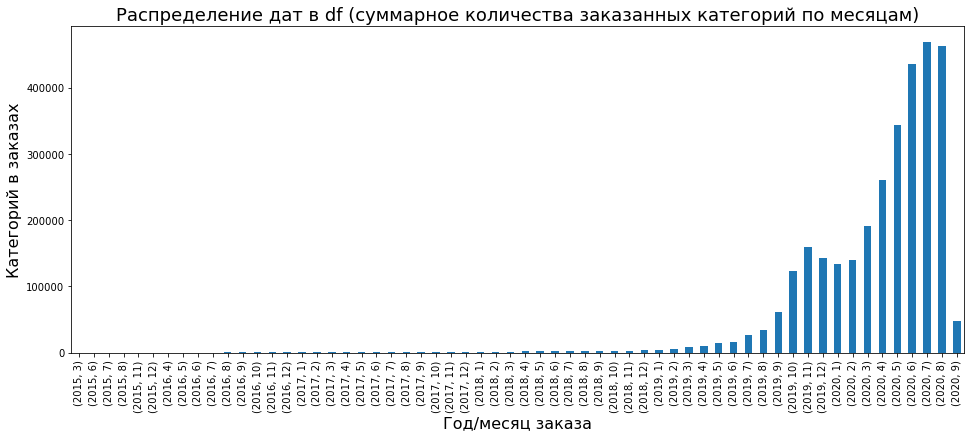

In [8]:
df['order_completed_at'].groupby([df['order_completed_at'].dt.year,
                                          df['order_completed_at'].dt.month]).count().plot(
    kind="bar", figsize=(16, 6))
plt.title('Распределение дат в df (суммарное количества заказанных категорий по месяцам)', fontsize=18) 
plt.ylabel('Категорий в заказах', fontsize=16)
plt.xlabel('Год/месяц заказа', fontsize=16);

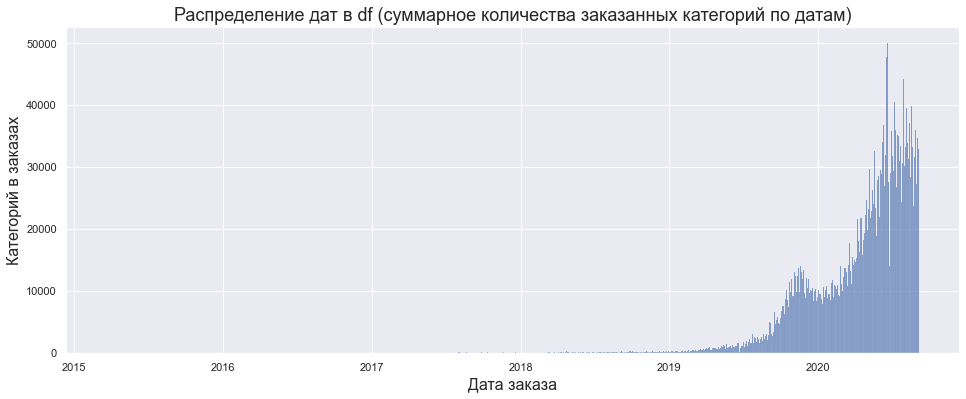

In [9]:
sns.set(rc={'figure.figsize':(16, 6)})

sns.histplot(df['order_completed_at'])
plt.title('Распределение дат в df (суммарное количества заказанных категорий по датам)', fontsize=18) 
plt.ylabel('Категорий в заказах', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16);

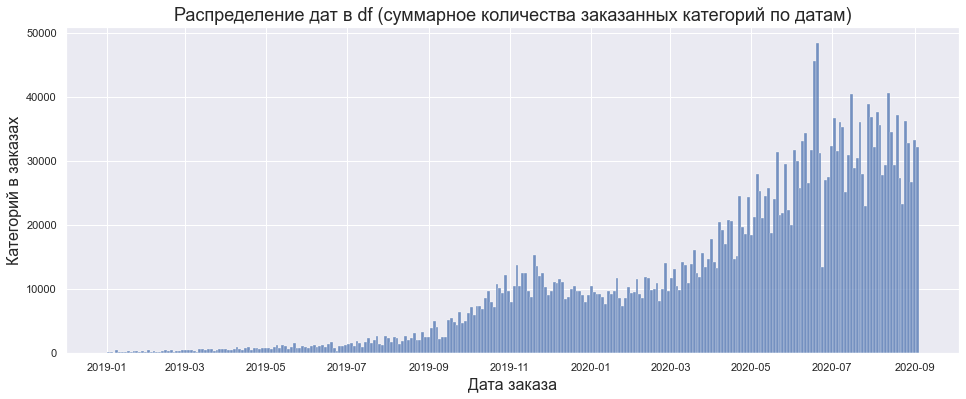

In [10]:
sns.histplot(df.query('order_completed_at > "2019"')['order_completed_at'])
plt.title('Распределение дат в df (суммарное количества заказанных категорий по датам)', fontsize=18) 
plt.ylabel('Категорий в заказах', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16);

#### Дата по покупателям

In [11]:
#дата первого/последнего заказа покупателя
first_last_user_date = df.pivot_table(index=['user_id'], aggfunc={'order_completed_at': ('min', 'max')})
first_last_user_date.set_axis(['last_order_date', 'first_order_date'], axis='columns', inplace=True)
first_last_user_date

,last_order_date,first_order_date
user_id,,
0,2020-09-02 07:38:25,2020-07-19 09:59:17
1,2020-07-14 10:20:58,2019-05-08 16:09:41
2,2020-06-18 18:31:08,2015-03-22 09:25:46
3,2020-06-24 13:07:29,2015-06-18 16:15:33
4,2020-08-27 13:54:48,2015-07-08 06:59:04
...,...,...
19995,2020-08-30 14:57:36,2020-08-30 07:24:10
19996,2020-09-02 07:45:27,2020-08-30 08:22:09
19997,2020-08-31 11:48:23,2020-08-30 11:23:41


In [12]:
print('минимальная дата первого заказа покупателя', first_last_user_date['first_order_date'].min())
print('максимальная дата первого заказа покупателя', first_last_user_date['first_order_date'].max())
print('минимальная дата последнего заказа покупателя', first_last_user_date['last_order_date'].min())
print('максимальная дата последнего заказа покупателя', first_last_user_date['last_order_date'].max())

минимальная дата первого заказа покупателя 2015-03-22 09:25:46
максимальная дата первого заказа покупателя 2020-09-01 03:10:14
минимальная дата последнего заказа покупателя 2020-06-06 04:21:22
максимальная дата последнего заказа покупателя 2020-09-03 23:45:45


In [13]:
'''
plt_date_hist = first_last_user_date.loc[:, 'last_order_date':'first_order_date'].astype(np.int64).plot.hist(
    bins=200, edgecolor='black', figsize=(16, 6), grid=True, alpha=0.4, density = True)

labels = plt_date_hist.get_xticks().tolist()
labels = pd.to_datetime(labels)
plt_date_hist.set_xticklabels(labels, rotation=90)
plt.title('Распределение даты первого/последнего заказа покупателей', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16)
plt.show();
'''

"\nplt_date_hist = first_last_user_date.loc[:, 'last_order_date':'first_order_date'].astype(np.int64).plot.hist(\n    bins=200, edgecolor='black', figsize=(16, 6), grid=True, alpha=0.4, density = True)\n\nlabels = plt_date_hist.get_xticks().tolist()\nlabels = pd.to_datetime(labels)\nplt_date_hist.set_xticklabels(labels, rotation=90)\nplt.title('Распределение даты первого/последнего заказа покупателей', fontsize=20) \nplt.ylabel('Частота', fontsize=16)\nplt.xlabel('Дата заказа', fontsize=16)\nplt.show();\n"

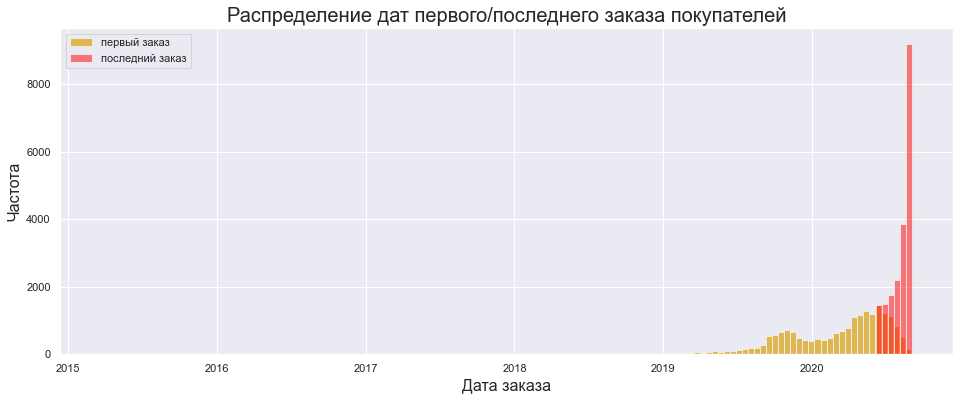

In [14]:
sns.histplot(first_last_user_date['first_order_date'], color='goldenrod')
sns.histplot(first_last_user_date['last_order_date'], color='red', bins=6, alpha=0.5)
plt.title('Распределение дат первого/последнего заказа покупателей', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16)
plt.legend(['первый заказ', 'последний заказ']);

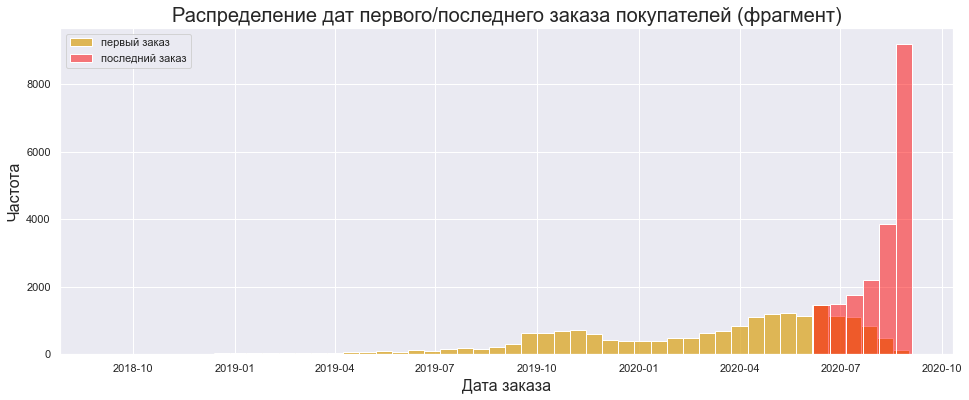

In [15]:
sns.histplot(first_last_user_date.query('first_order_date > "2018-09-01"')['first_order_date'], 
             color='goldenrod')
sns.histplot(first_last_user_date['last_order_date'], color='red', bins=6, alpha=0.5)
plt.title('Распределение дат первого/последнего заказа покупателей (фрагмент)', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16)
plt.legend(['первый заказ', 'последний заказ']);

In [16]:
# Дата отсечки
day_x = pd.to_datetime('2020-09-04')

In [17]:
#df сгруппированный по покупателю + заказу
user_order_count = df.pivot_table(index=['user_id', 'order_completed_at'], aggfunc={'cart': ('count', list)})
user_order_count['user_id_order'] = user_order_count.index
user_order_count = user_order_count.reset_index()
user_order_count.set_axis(['user_id', 'order_completed_at', 'cart_count', 'cart_list',
                          'user_id_order'], axis='columns', inplace=True)
user_order_count['cart_count'] = user_order_count['cart_count'].astype('int')
display(user_order_count)

,user_id,order_completed_at,cart_count,cart_list,user_id_order
0,0,2020-07-19 09:59:17,8,"[20, 82, 441, 57, 14, 405, 430, 379]","(0, 2020-07-19 09:59:17)"
1,0,2020-08-24 08:55:32,25,"[133, 5, 26, 10, 382, 14, 22, 41, 25, 441, 411...","(0, 2020-08-24 08:55:32)"
2,0,2020-09-02 07:38:25,11,"[803, 170, 84, 61, 440, 57, 55, 401, 398, 399,...","(0, 2020-09-02 07:38:25)"
3,1,2019-05-08 16:09:41,1,[55],"(1, 2019-05-08 16:09:41)"
4,1,2020-01-17 14:44:23,6,"[82, 798, 86, 421, 204, 55]","(1, 2020-01-17 14:44:23)"
...,...,...,...,...,...
209401,19998,2020-09-01 08:12:32,7,"[398, 57, 84, 61, 415, 6, 420]","(19998, 2020-09-01 08:12:32)"
209402,19998,2020-09-02 15:03:23,4,"[84, 798, 409, 19]","(19998, 2020-09-02 15:03:23)"
209403,19999,2020-08-31 18:54:24,1,[326],"(19999, 2020-08-31 18:54:24)"
209404,19999,2020-08-31 19:32:08,1,[326],"(19999, 2020-08-31 19:32:08)"


In [18]:
#даты заказов по покупателям
user_order_list = user_order_count.pivot_table(index=['user_id'], aggfunc={'order_completed_at': ('max', list)})
user_order_list.set_axis(['user_buy_date_list', 'last_order_date'], axis='columns', inplace=True)
user_order_list['second_to_last_order_date']=user_order_list.apply(second_to_last_date, axis=1)
display(user_order_list)

,user_buy_date_list,last_order_date,second_to_last_order_date
user_id,,,
0,"[2020-07-19 09:59:17, 2020-08-24 08:55:32, 202...",2020-09-02 07:38:25,2020-08-24 08:55:32
1,"[2019-05-08 16:09:41, 2020-01-17 14:44:23, 202...",2020-07-14 10:20:58,2020-05-24 11:13:59
2,"[2015-03-22 09:25:46, 2016-05-27 19:21:46, 201...",2020-06-18 18:31:08,2020-01-11 16:50:15
3,"[2015-06-18 16:15:33, 2015-07-04 14:05:22, 201...",2020-06-24 13:07:29,2020-06-12 14:49:01
4,"[2015-07-08 06:59:04, 2020-04-18 06:36:22, 202...",2020-08-27 13:54:48,2020-06-21 07:07:52
...,...,...,...
19995,"[2020-08-30 07:24:10, 2020-08-30 14:51:42, 202...",2020-08-30 14:57:36,2020-08-30 14:51:42
19996,"[2020-08-30 08:22:09, 2020-08-30 08:35:57, 202...",2020-09-02 07:45:27,2020-08-30 08:35:57
19997,"[2020-08-30 11:23:41, 2020-08-31 11:04:05, 202...",2020-08-31 11:48:23,2020-08-31 11:04:05


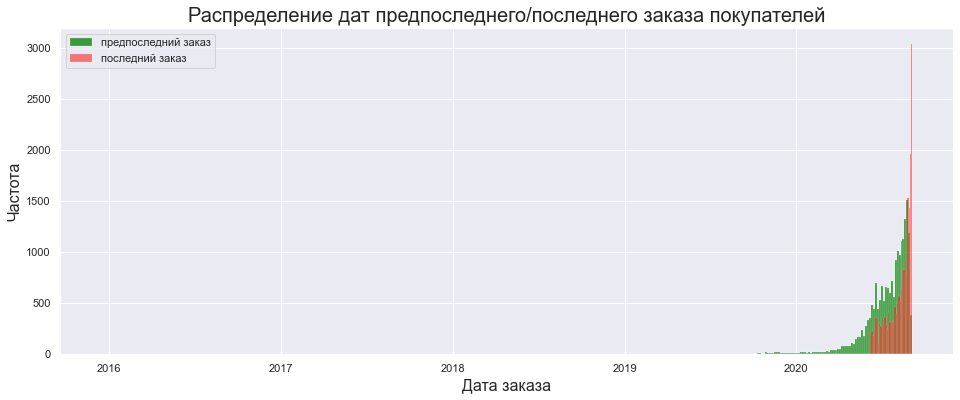

In [19]:
sns.histplot(user_order_list['second_to_last_order_date'], color='green')
sns.histplot(user_order_list['last_order_date'], color='red', alpha=0.5)
plt.title('Распределение дат предпоследнего/последнего заказа покупателей', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16)
plt.legend(['предпоследний заказ', 'последний заказ']);

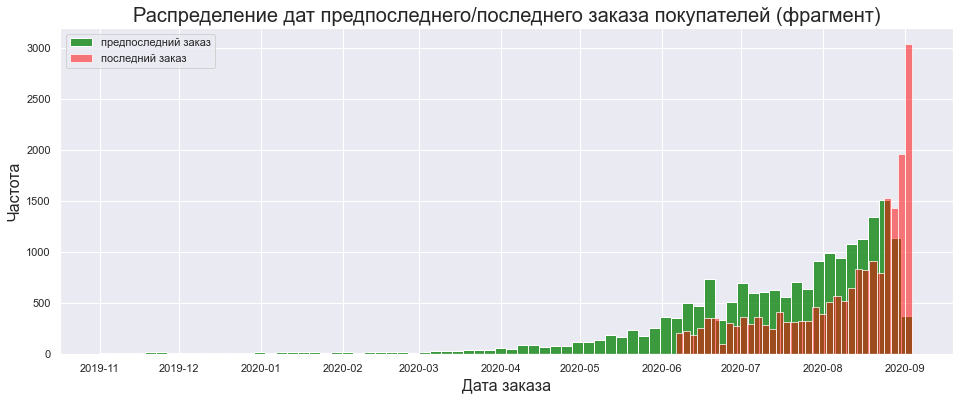

In [20]:
sns.histplot(user_order_list.query('second_to_last_order_date > "2019-11-01"')['second_to_last_order_date'],
             color='green')
sns.histplot(user_order_list['last_order_date'], color='red', alpha=0.5)
plt.title('Распределение дат предпоследнего/последнего заказа покупателей (фрагмент)', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16)
plt.legend(['предпоследний заказ', 'последний заказ']);

In [21]:
user_order_list['days_last_second_to_last'] = (user_order_list['last_order_date'] 
                                               - user_order_list['second_to_last_order_date']).dt.days

In [22]:
display(user_order_list.describe())
user_order_list['days_last_second_to_last'].quantile(0.90)

,days_last_second_to_last
count,20000.000000
mean,29.565550
std,49.025999
min,0.000000
25%,6.000000
50%,14.000000
75%,32.000000
max,1720.000000


68.0

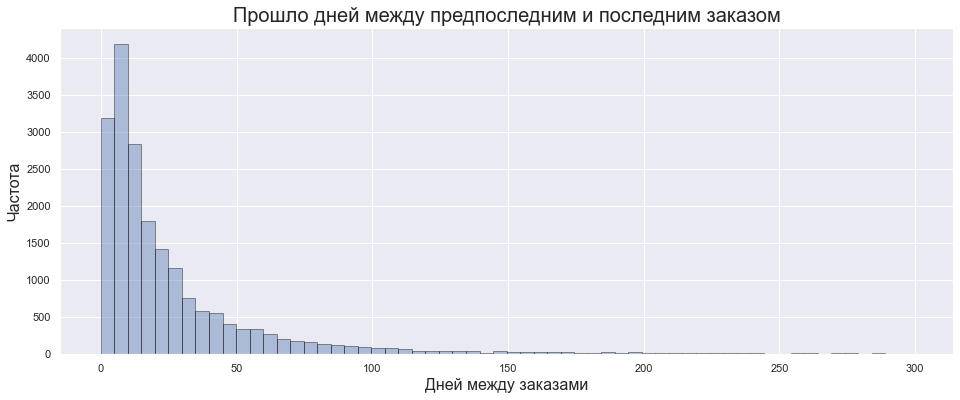

In [23]:
user_order_list['days_last_second_to_last'].plot.hist(
    range=(0, 299), bins=60, edgecolor='black', figsize=(16, 6), grid=True, alpha=0.4)

plt.title('Прошло дней между предпоследним и последним заказом', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Дней между заказами', fontsize=16);

In [24]:
#количество заказов покупателей до/после даты
for date in ['2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2019-09-04', '2020-01-01']:
    order_count_before = user_order_count[user_order_count['order_completed_at'] < date]
    order_count_after = user_order_count[user_order_count['order_completed_at'] > date]
    print(date, 'слева', len(order_count_before.index), len(order_count_before.index)/209406,
                'справа', len(order_count_after.index), len(order_count_after.index)/209406)

2016-01-01 слева 10 4.775412356857015e-05 справа 209396 0.9999522458764314
2017-01-01 слева 113 0.0005396215963248427 справа 209293 0.9994603784036752
2018-01-01 слева 737 0.0035194789070036197 справа 208669 0.9964805210929963
2019-01-01 слева 2422 0.011566048728307689 справа 206984 0.9884339512716923
2019-09-04 слева 9403 0.04490320239152651 справа 200003 0.9550967976084735
2020-01-01 слева 36922 0.1763177750398747 справа 172484 0.8236822249601253


#### Дата по категориям

In [25]:
#дата первого/последнего заказа категории
cart_first_last_date = df.pivot_table(index=['cart'], aggfunc={'order_completed_at': ('min', 'max')})
cart_first_last_date.set_axis(['last_cart_date', 'first_cart_date'], axis='columns', inplace=True)
cart_first_last_date

,last_cart_date,first_cart_date
cart,,
0,2020-09-03 21:34:35,2016-08-13 02:54:47
1,2020-09-03 11:26:45,2017-08-17 10:51:15
2,2020-08-22 22:04:57,2019-04-19 08:27:24
3,2018-09-16 08:14:25,2018-09-16 08:14:25
4,2020-08-27 17:58:25,2017-08-22 09:49:22
...,...,...
876,2020-08-25 18:24:36,2020-08-12 12:59:56
877,2020-08-26 19:30:19,2020-08-14 18:08:18
878,2020-08-27 11:31:29,2020-08-14 22:07:30


In [26]:
print('минимальная дата первого заказа категории', cart_first_last_date['first_cart_date'].min())
print('максимальная дата первого заказа категории', cart_first_last_date['first_cart_date'].max())
print('минимальная дата последнего заказа категории', cart_first_last_date['last_cart_date'].min())
print('максимальная дата последнего заказа категории', cart_first_last_date['last_cart_date'].max())

минимальная дата первого заказа категории 2015-03-22 09:25:46
максимальная дата первого заказа категории 2020-09-01 12:58:32
минимальная дата последнего заказа категории 2017-11-16 11:58:50
максимальная дата последнего заказа категории 2020-09-03 23:45:45


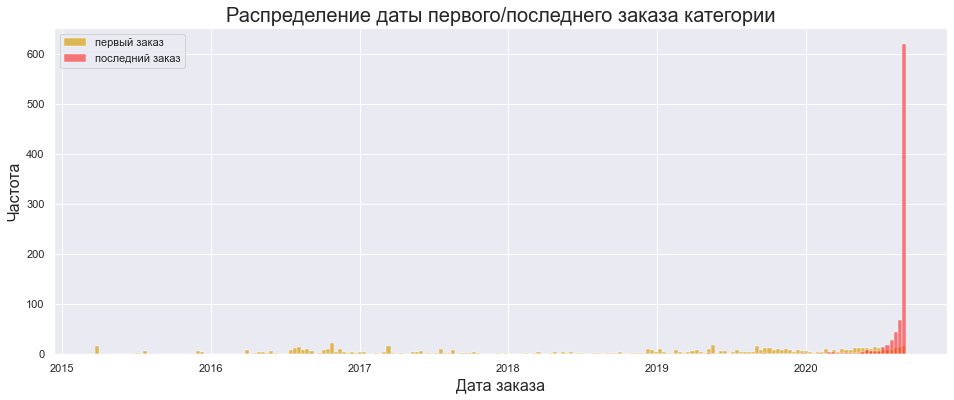

In [27]:
sns.histplot(cart_first_last_date['first_cart_date'], color='goldenrod', bins=200)
sns.histplot(cart_first_last_date['last_cart_date'], color='red', alpha=0.5, bins=100)
plt.title('Распределение даты первого/последнего заказа категории', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16)
plt.legend(['первый заказ', 'последний заказ']);

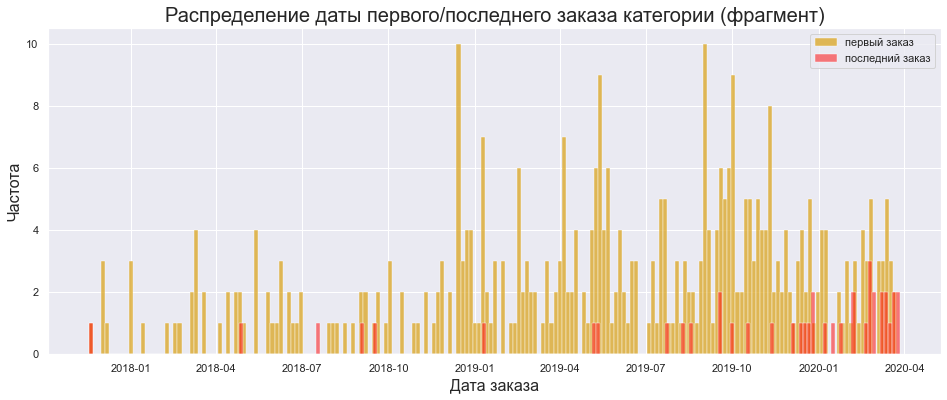

In [28]:
sns.histplot(cart_first_last_date.query(
    'first_cart_date > "2017-11-01" & first_cart_date < "2020-04-01"')['first_cart_date'], color='goldenrod', bins=200)
sns.histplot(cart_first_last_date.query(
    'last_cart_date > "2017-11-01" & last_cart_date < "2020-04-01"')['last_cart_date'], color='red', alpha=0.5, bins=200)
plt.title('Распределение даты первого/последнего заказа категории (фрагмент)', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Дата заказа', fontsize=16)
plt.legend(['первый заказ', 'последний заказ']);

### Покупатели

In [29]:
display(user_order_count)

,user_id,order_completed_at,cart_count,cart_list,user_id_order
0,0,2020-07-19 09:59:17,8,"[20, 82, 441, 57, 14, 405, 430, 379]","(0, 2020-07-19 09:59:17)"
1,0,2020-08-24 08:55:32,25,"[133, 5, 26, 10, 382, 14, 22, 41, 25, 441, 411...","(0, 2020-08-24 08:55:32)"
2,0,2020-09-02 07:38:25,11,"[803, 170, 84, 61, 440, 57, 55, 401, 398, 399,...","(0, 2020-09-02 07:38:25)"
3,1,2019-05-08 16:09:41,1,[55],"(1, 2019-05-08 16:09:41)"
4,1,2020-01-17 14:44:23,6,"[82, 798, 86, 421, 204, 55]","(1, 2020-01-17 14:44:23)"
...,...,...,...,...,...
209401,19998,2020-09-01 08:12:32,7,"[398, 57, 84, 61, 415, 6, 420]","(19998, 2020-09-01 08:12:32)"
209402,19998,2020-09-02 15:03:23,4,"[84, 798, 409, 19]","(19998, 2020-09-02 15:03:23)"
209403,19999,2020-08-31 18:54:24,1,[326],"(19999, 2020-08-31 18:54:24)"
209404,19999,2020-08-31 19:32:08,1,[326],"(19999, 2020-08-31 19:32:08)"


In [30]:
#количество заказов, среднее количество категорий в заказе, даты первого/последнего заказа покупателя
user_count = user_order_count.pivot_table(index=['user_id'], aggfunc={'order_completed_at': ('min', 'max'),  
                                                         'cart_count': ('count', 'mean')})
#user_count = user_order_count.reset_index()
user_count.set_axis(['user_buy_count', 'user_cart_count_mean', 
                     'user_buy_date_max', 'user_buy_date_min'], axis='columns', inplace=True)
display(user_count)

,user_buy_count,user_cart_count_mean,user_buy_date_max,user_buy_date_min
user_id,,,,
0,3.0,14.666667,2020-09-02 07:38:25,2020-07-19 09:59:17
1,9.0,4.111111,2020-07-14 10:20:58,2019-05-08 16:09:41
2,15.0,11.466667,2020-06-18 18:31:08,2015-03-22 09:25:46
3,7.0,8.857143,2020-06-24 13:07:29,2015-06-18 16:15:33
4,8.0,14.000000,2020-08-27 13:54:48,2015-07-08 06:59:04
...,...,...,...,...
19995,3.0,3.000000,2020-08-30 14:57:36,2020-08-30 07:24:10
19996,3.0,5.666667,2020-09-02 07:45:27,2020-08-30 08:22:09
19997,3.0,14.000000,2020-08-31 11:48:23,2020-08-30 11:23:41


In [31]:
#количество дней с первого/последнего заказа, среднее время между заказами покупателя.
user_count['first_buy_days_ago'] = (day_x - user_count['user_buy_date_min']).dt.days
user_count['last_buy_days_ago'] = (day_x - user_count['user_buy_date_max']).dt.days
user_count['first_last_buy_delta'] = user_count['first_buy_days_ago']  - user_count['last_buy_days_ago']
user_count['buy_delta_mean'] = user_count['first_last_buy_delta']/(user_count['user_buy_count']-1)
display(user_count)

,user_buy_count,user_cart_count_mean,user_buy_date_max,user_buy_date_min,first_buy_days_ago,last_buy_days_ago,first_last_buy_delta,buy_delta_mean
user_id,,,,,,,,
0,3.0,14.666667,2020-09-02 07:38:25,2020-07-19 09:59:17,46,1,45,22.500000
1,9.0,4.111111,2020-07-14 10:20:58,2019-05-08 16:09:41,484,51,433,54.125000
2,15.0,11.466667,2020-06-18 18:31:08,2015-03-22 09:25:46,1992,77,1915,136.785714
3,7.0,8.857143,2020-06-24 13:07:29,2015-06-18 16:15:33,1904,71,1833,305.500000
4,8.0,14.000000,2020-08-27 13:54:48,2015-07-08 06:59:04,1884,7,1877,268.142857
...,...,...,...,...,...,...,...,...
19995,3.0,3.000000,2020-08-30 14:57:36,2020-08-30 07:24:10,4,4,0,0.000000
19996,3.0,5.666667,2020-09-02 07:45:27,2020-08-30 08:22:09,4,1,3,1.500000
19997,3.0,14.000000,2020-08-31 11:48:23,2020-08-30 11:23:41,4,3,1,0.500000


In [32]:
user_count.describe()

,user_buy_count,user_cart_count_mean,first_buy_days_ago,last_buy_days_ago,first_last_buy_delta,buy_delta_mean
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10.470300,14.426739,199.143950,25.908900,173.235050,28.798111
std,11.905856,6.402802,161.804004,25.131721,161.131711,33.582145
min,3.000000,1.000000,2.000000,0.000000,0.000000,0.000000
25%,4.000000,10.111111,88.000000,5.000000,61.000000,10.400000
50%,6.000000,13.714286,150.000000,17.000000,126.000000,18.468627
75%,12.000000,18.000000,289.000000,42.000000,257.000000,34.000000
max,213.000000,64.400000,1992.000000,89.000000,1915.000000,866.500000


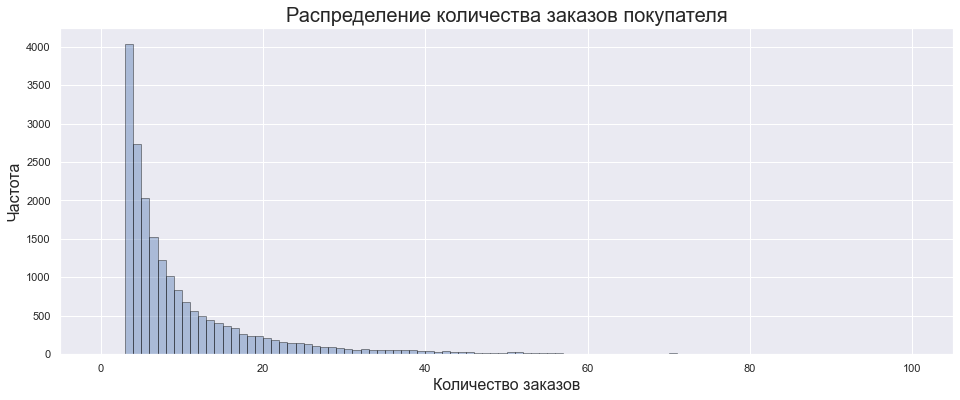

In [33]:
user_count['user_buy_count'].plot.hist(bins=100, range=(0, 100), edgecolor='black', figsize=(16, 6), grid=True, alpha=0.4)
plt.title('Распределение количества заказов покупателя', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Количество заказов', fontsize=16);

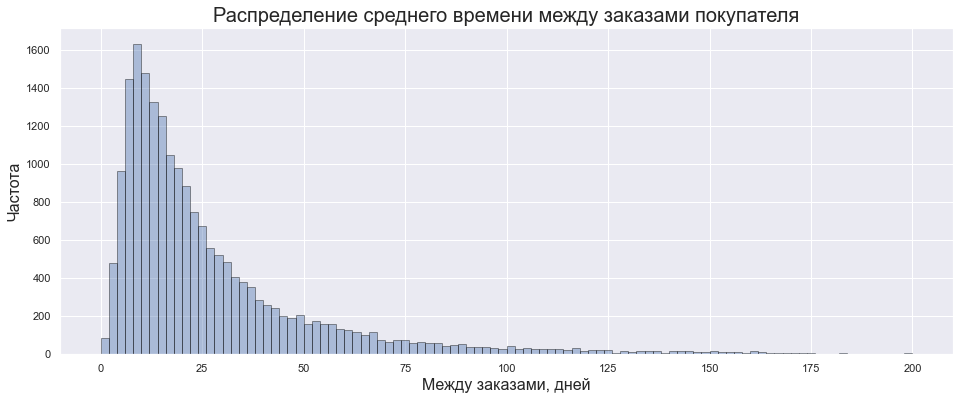

In [34]:
user_count['buy_delta_mean'].plot.hist(bins=100, range=(0, 200), edgecolor='black', figsize=(16, 6), grid=True, alpha=0.4)
plt.title('Распределение среднего времени между заказами покупателя', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Между заказами, дней', fontsize=16);

In [35]:
#сколько категорий (какие) в заказах покупателей
user_cart_list = df.pivot_table(index=['user_id'], 
                                aggfunc={'cart': (lambda x: list(x.unique()) , 'count', pd.Series.nunique)})
#user_count = user_order_count.reset_index()
user_cart_list.set_axis(['user_cart_list', 'user_cart', 'user_unique_cart'], axis='columns', inplace=True)
display(user_cart_list)

,user_cart_list,user_cart,user_unique_cart
user_id,,,
0,"[20, 82, 441, 57, 14, 405, 430, 379, 133, 5, 2...",44,36
1,"[55, 82, 798, 86, 421, 204, 23, 14, 231, 88, 1...",37,20
2,"[399, 14, 198, 88, 157, 82, 134, 16, 409, 384,...",172,74
3,"[399, 804, 134, 41, 712, 100, 382, 442, 62, 37...",62,38
4,"[54, 55, 22, 383, 384, 102, 98, 391, 100, 5, 6...",112,50
...,...,...,...
19995,"[67, 14, 398, 84, 57, 393, 31, 0, 712]",9,9
19996,"[393, 82, 92, 396, 84, 231, 61, 431, 404, 409,...",17,17
19997,"[443, 382, 383, 49, 77, 479, 218, 99, 203, 55,...",42,38


### Категории

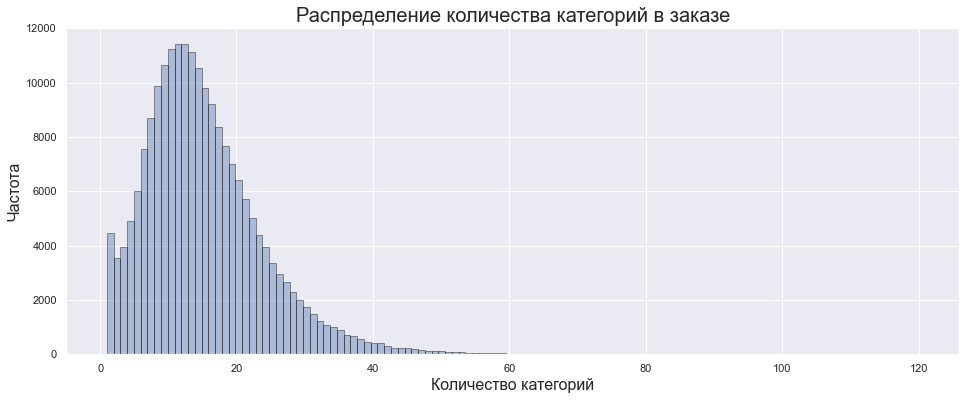

In [36]:
user_order_count['cart_count'].plot.hist(bins=120, edgecolor='black', figsize=(16, 6), grid=True, alpha=0.4)
plt.title('Распределение количества категорий в заказе', fontsize=20) 
plt.ylabel('Частота', fontsize=16)
plt.xlabel('Количество категорий', fontsize=16);

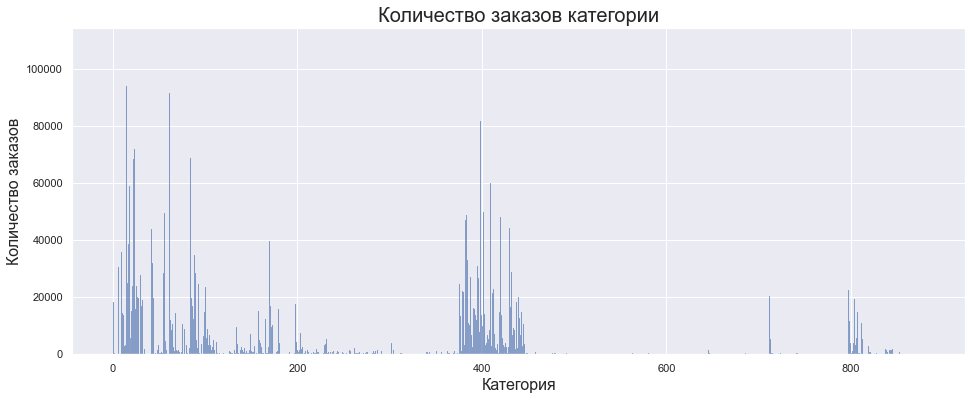

In [37]:
sns.histplot(df['cart'], bins=881)
plt.title('Количество заказов категории', fontsize=20) 
plt.ylabel('Количество заказов', fontsize=16)
plt.xlabel('Категория', fontsize=16);

In [38]:
#Количество заказов (всего) и покупателей (заказавших хотя бы раз) категории.
cart_count = df.pivot_table(index=['cart'], aggfunc={'user_id': ('count', pd.Series.nunique)})
cart_count.set_axis(['cart_buy_count', 'cart_buy_user_count'], axis='columns', inplace=True)
display(cart_count)

,cart_buy_count,cart_buy_user_count
cart,,
0,18387,8076
1,357,217
2,30,25
3,1,1
4,219,190
...,...,...
876,2,2
877,5,4
878,6,6


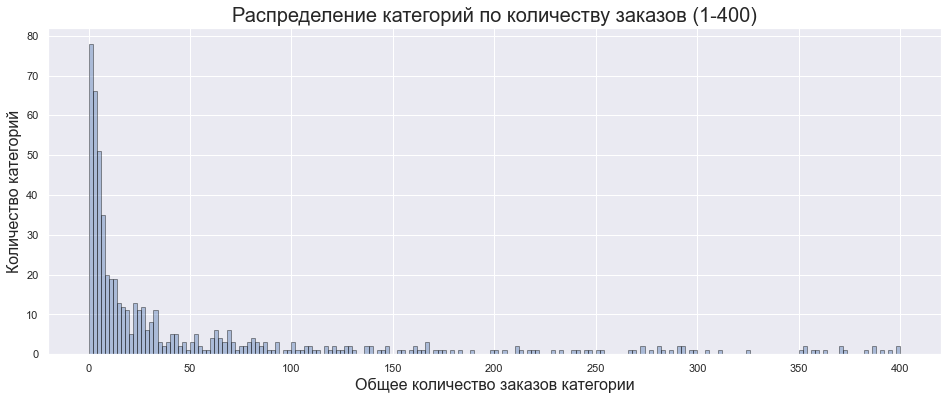

In [39]:
cart_count['cart_buy_count'].plot.hist(range=(0, 400), bins=200, edgecolor='black', figsize=(16, 6), grid=True, alpha=0.4)
plt.title('Распределение категорий по количеству заказов (1-400)', fontsize=20) 
plt.ylabel('Количество категорий', fontsize=16)
plt.xlabel('Общее количество заказов категории', fontsize=16);

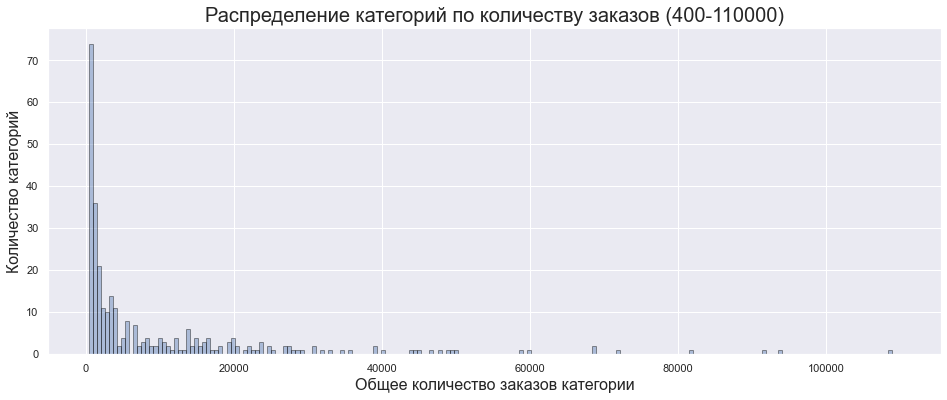

In [40]:
cart_count['cart_buy_count'].plot.hist(range=(400, 110000), bins=200, edgecolor='black', figsize=(16, 6), grid=True, alpha=0.4)
plt.title('Распределение категорий по количеству заказов (400-110000)', fontsize=20) 
plt.ylabel('Количество категорий', fontsize=16)
plt.xlabel('Общее количество заказов категории', fontsize=16);

In [41]:
cart_count.describe()

,cart_buy_count,cart_buy_user_count
count,881.000000,881.000000
mean,3544.908059,1268.558456
std,10686.317664,2812.280068
min,1.000000,1.000000
25%,7.000000,6.000000
50%,66.000000,60.000000
75%,1101.000000,801.000000
max,108877.000000,16994.000000


### data_sample_submission

In [42]:
sample_sub

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0
...,...,...
790444,19998;26,0
790445,19998;31,0
790446,19998;29,1
790447,19998;798,1


In [43]:
sample_sub[['user_id','cart']] = sample_sub['id'].str.split(';', expand=True)
sample_sub

,id,target,user_id,cart
0,0;133,0,0,133
1,0;5,1,0,5
2,0;10,0,0,10
3,0;396,1,0,396
4,0;14,0,0,14
...,...,...,...,...
790444,19998;26,0,19998,26
790445,19998;31,0,19998,31
790446,19998;29,1,19998,29
790447,19998;798,1,19998,798


In [44]:
print('дубликатов:', sample_sub.duplicated().sum())
print()
print('кол-во уникальных покупателей:', sample_sub['user_id'].nunique())
print()
print('кол-во уникальных категорий:', sample_sub['cart'].nunique())

дубликатов: 0

кол-во уникальных покупателей: 13036

кол-во уникальных категорий: 858


### Выводы по данным  

* Пропусков нет, дубликатов нет

* Странный пик заказов 20 июня 2020 и провал 22-23 июня 2020
* Покупок до 2019г. - 1.1%, до 2020г. - 18%
* Дата отсечки - 03.09.2020

* 20 000 покупателей 
  *            последняя покупка не ранее 90 дней до отсечки (06,06,2020 - 03,09,2020)
  *            покупок не менее 3
* Половина покупателей делает заказ раз в месяц и чаще
* В большинстве случаев следующий заказ стоит ждать не позднее 30 (60) дней
* Медианное количество заказов покупателя - 6
* Медианное количество категорий в заказе покупателя - 14 (доходит до 64)

* 881 категория товаров
  * Новые категории вводились на протяжении всего периода (есть совсем свежие)
  * Часть категорий не покупалась с конца 2017г (16.11.2017) и далее - возможно выведены 
* Есть очень популярные (18 категорий с продажами более 40000)  
и крайне редкие категории (половина категорий куплена менее 66 раз)

* Предсказание необходимо для 858 категорий из 881 (97%) и 13036 покупателей из 20000 (65%)

## Подготовка признаков

Вижу два варианта выделение целевой покупки:
* по номеру покупки - брать в качестве target последнюю, предпоследнюю и т.д. покупки
* по дате - отсекать выборку по определенной дате и брать в качестве target первую покупку после неё.

|  | Плюсы | Минусы |
| ---: | :--- | :--- |
| По номеру:| Максимальный объем обучающих данных | Часть данных не актуальна (для некоторых покупателей 2 покупка уже очень давно) |
|  |  | Нет привязки к дате. |

|  | Плюсы | Минусы |
| ---: | :--- | :--- |
| По дате: | Повторяет условия задачи | Теряется значительная часть строк (нет целевой покупки или несколько покупок после даты) |
|  | Легко ввести сезонные и пр. признаки связанные с датой |  |

In [45]:
#Нумеруем заказы покупателей от последнего к первому
df = df.merge(user_order_list['user_buy_date_list'], on=['user_id'], how='outer')
df['reverse_buy_num'] = df.apply(buy_num, axis=1)
df = df.drop('user_buy_date_list', axis=1)

### По номеру покупки

In [46]:
df_train = pd.DataFrame()

In [48]:
#Обрезаем данные по номеру покупки (нумерация обратная)
for cut_num in range(12): #[0, 1, 2]:
    df_cut = df[df['reverse_buy_num'] > cut_num]

    # Признаки покупателя + категории
    df_train_1 = df_cut.pivot_table(index=['user_id', 'cart'], aggfunc={'order_completed_at': (min, max), 
                                                                  'reverse_buy_num': ('count')})
    df_train_1 = df_train_1.reset_index()
    df_train_1.set_axis(['user_id', 'cart', 'user_cart_date_max', 'user_cart_date_min', 
                                      'user_cart_buy_count'], axis='columns', inplace=True)

    if cut_num > 0:
        #Целевой признак
        df_target = df[df['reverse_buy_num'] == cut_num]
        df_target = df_target.pivot_table(index=['user_id', 'cart'], aggfunc={'reverse_buy_num': ('count')}).reset_index()
        df_train_1['target'] = df_train_1.merge(df_target, how='left', on=['user_id', 'cart'])['reverse_buy_num'].fillna(0)

        #количество вхождений категории в последние 1, 2, 3, 5, 7, 10 заказов покупателя
    for order_num in [1, 2, 3, 5, 7, 10]:
        df_norder = df_cut[df_cut['reverse_buy_num'] <= order_num + cut_num]
        df_norder = df_norder.pivot_table(index=['user_id', 'cart'], aggfunc={'reverse_buy_num': ('count')})
        col_name = 'in_last' + str(order_num)
        df_train_1[col_name] = df_train_1.merge(df_norder,how='left',on=['user_id','cart'])['reverse_buy_num'].fillna(0)


    #признаки покупателя
    df_train_2 = df_cut.pivot_table(index=['user_id'], aggfunc={'reverse_buy_num': (pd.Series.nunique), 
                                           'order_completed_at': (min, max), 
                                           'cart': ('count', pd.Series.nunique)})
    df_train_2 = df_train_2.reset_index()
    df_train_2.set_axis(['user_id', 'user_cart_count', 'user_cart_nunique',
                    'user_last_date', 'user_first_date', 'user_order_count'], axis='columns', inplace=True)
    df_train_2['user_cart_mean'] = df_train_2['user_cart_count']/df_train_2['user_order_count']
    df_train_2['user_lifetime'] = (df_train_2['user_last_date'].astype('datetime64') - 
                                df_train_2['user_first_date'].astype('datetime64')).dt.days
    df_train_2 = df_train_2.drop(['user_last_date', 'user_first_date'], axis=1)

        # даты последних заказов покупателя
    df_user_order_dates = df[df['reverse_buy_num'] > cut_num]
    df_user_order_dates = df_user_order_dates[df_user_order_dates['reverse_buy_num'] <= cut_num+10]
    df_user_order_dates = df_user_order_dates.pivot_table(index=['user_id'],
                                                      columns=['reverse_buy_num'],
                                                      aggfunc={'order_completed_at': (min)})
    df_user_order_dates = df_user_order_dates.reset_index()
    df_user_order_dates.set_axis(['user_id', 'user_last_order_date', 'last2', 'last3', 'last4', 'last5', 
                              'last6', 'last7', 'last8', 'last9', 'last10'], axis='columns', inplace=True)

        # дней между последним и 2-10 заказами
    for col in ['last2', 'last3', 'last4', 'last5', 'last6', 'last7', 'last8', 'last9', 'last10']:
        df_user_order_dates[col] = (df_user_order_dates['user_last_order_date'].astype('datetime64') - 
                                df_user_order_dates[col].astype('datetime64')).dt.days

        # оставляем дельту для последнего и 2, 3, 5, 7, 10 заказов
    for col in ['last4', 'last6', 'last8', 'last9']:
        df_user_order_dates = df_user_order_dates.drop(col, axis=1)
    df_user_order_dates.set_axis(['user_id', 'user_last_order_date', 'delta2',
                              'delta3','delta5','delta7','delta10'], axis='columns', inplace=True)

        #пропуски заполним значением 1000 лет
    df_user_order_dates = df_user_order_dates.fillna(365000)

    df_train_2 = df_train_2.merge(df_user_order_dates, how='inner', on='user_id')

    
    #признаки категории
    df_train_3 = df_cut.pivot_table(index=['cart'], aggfunc={'order_completed_at': (min, max),
                                                         'user_id': ('count', pd.Series.nunique),
                 'reverse_buy_num': (lambda x: np.quantile(x, 0.25)-cut_num, lambda x: np.quantile(x, 0.1)-cut_num)})
    df_train_3.set_axis(['cart_last_date', 'cart_first_date', 'cart_buy_num_q25', 'cart_buy_num_q10',
                     'cart_order_count','cart_user_count'], axis='columns', inplace=True)
    df_train_3['cart_reord_coef'] = df_train_3['cart_order_count'] / df_train_3['cart_user_count']

        #количество вхождений категории в последние 1, 2, 3, 5, 7, 10 заказов (по всем покупателям)
    for order_num in [1, 2, 3, 5, 7, 10]:
        df_norder = df_cut[df_cut['reverse_buy_num'] <= order_num + cut_num]
        df_norder = df_norder.pivot_table(index=['cart'], aggfunc={'reverse_buy_num': ('count')})
        col_name = 'cart_in_last' + str(order_num)
        df_train_3[col_name] = df_train_3.merge(
            df_norder, how='left', on='cart')['reverse_buy_num'] / df_train_3['cart_order_count']
    df_train_3 = df_train_3.fillna(0)

    #объединяем признаки
    df_train_0 = df_train_1.merge(df_train_2, how='left', on='user_id')
    df_train_0 = df_train_0.merge(df_train_3, how='left', on='cart')

    # Вычисляемые признаки покупателя + категории 
    df_train_0['user_cart_ratio'] = df_train_0['user_cart_buy_count']/df_train_0['user_order_count']
    cart_more1 = df_train_0[df_train_0['user_cart_buy_count']>1].groupby('cart')['user_id'].count()
    df_train_0['cart_more1_ratio'] = df_train_0.loc[:, 'cart':'user_cart_date_max'].merge(
                                             cart_more1, how='left', on='cart')['user_id']/df_train_0['cart_user_count']
    df_train_0 = df_train_0.fillna(0)
    
    #даты к числам
    df_train_0['user_cart_date_max'] = (df_train_0['user_last_order_date'] - df_train_0['user_cart_date_max']).dt.days
    df_train_0['user_cart_date_min'] = (df_train_0['user_last_order_date'] - df_train_0['user_cart_date_min']).dt.days
    df_train_0['cart_last_date'] = (df_train_0['user_last_order_date'] - df_train_0['cart_last_date']).dt.days
    df_train_0['cart_first_date'] = (df_train_0['user_last_order_date'] - df_train_0['cart_first_date']).dt.days
    df_train_0 = df_train_0.drop('user_last_order_date', axis=1)
    
    #признаки для прогноза
    if cut_num == 0:
        data_pred = df_train_0.copy()
    
    #отрезаем тестовую выборку (для теста выбраны все последние покупки)
    elif cut_num == 1:
        df_FINAL_train = df_train_0.copy()
        data_train, data_test = train_test_split(df_train_0, test_size=0.99999, random_state=123)
    
    #обогащаем тренировочные выборки данными более ранних продаж
    else:
        data_train = pd.concat([data_train, df_train_0])
        df_FINAL_train = pd.concat([df_FINAL_train, df_train_0])
        
        if cut_num == 2:
            data_train_1 = data_train.copy() #тренировочные данные для одной продажи

**Список полученных фреймов см. в п. [4.3 "Варианты обучающих и тестовых данных"](#43)**

In [49]:
data_train.head(3)

,user_id,cart,user_cart_date_max,user_cart_date_min,user_cart_buy_count,target,in_last1,in_last2,in_last3,in_last5,in_last7,in_last10,user_cart_count,user_cart_nunique,user_order_count,user_cart_mean,user_lifetime,delta2,delta3,delta5,delta7,delta10,cart_last_date,cart_first_date,cart_buy_num_q25,cart_buy_num_q10,cart_order_count,cart_user_count,cart_reord_coef,cart_in_last1,cart_in_last2,cart_in_last3,cart_in_last5,cart_in_last7,cart_in_last10,user_cart_ratio,cart_more1_ratio
653418,10374,421,101,101,1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,104,64,5,20.8,101,19.0,20.0,101.0,365000.0,365000.0,-47,1379,3.0,1.0,12678,5829,2.174987,0.100726,0.205868,0.298075,0.431141,0.529973,0.643477,0.20,0.446560
990803,18641,14,0,0,1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,42,38,2,21.0,18,18.0,365000.0,365000.0,365000.0,365000.0,-30,1962,3.0,1.0,85164,15273,5.576115,0.100970,0.202703,0.283946,0.412040,0.507785,0.615354,0.50,0.769332
670737,10733,0,36,36,1,0.0,0.0,1.0,1.0,1.0,1.0,1.0,32,21,4,8.0,87,36.0,62.0,365000.0,365000.0,365000.0,-76,1406,3.0,1.0,16494,7339,2.247445,0.112829,0.219777,0.302110,0.425427,0.519825,0.624227,0.25,0.453059


In [50]:
data_test.head(3)

,user_id,cart,user_cart_date_max,user_cart_date_min,user_cart_buy_count,target,in_last1,in_last2,in_last3,in_last5,in_last7,in_last10,user_cart_count,user_cart_nunique,user_order_count,user_cart_mean,user_lifetime,delta2,delta3,delta5,delta7,delta10,cart_last_date,cart_first_date,cart_buy_num_q25,cart_buy_num_q10,cart_order_count,cart_user_count,cart_reord_coef,cart_in_last1,cart_in_last2,cart_in_last3,cart_in_last5,cart_in_last7,cart_in_last10,user_cart_ratio,cart_more1_ratio
148452,2079,798,75,293,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,824,177,36,22.888889,324,5,10.0,18.0,25.0,39.0,-6,1564,3.0,1.0,20433,9296,2.198042,0.106641,0.216561,0.302403,0.438066,0.537170,0.647090,0.083333,0.474613
765502,12728,100,0,83,4,1.0,1.0,1.0,2.0,2.0,2.0,3.0,180,66,14,12.857143,104,28,35.0,50.0,55.0,77.0,-29,1460,3.0,2.0,21518,4924,4.370024,0.091179,0.182127,0.258156,0.380519,0.476438,0.589599,0.285714,0.624898
146062,2044,141,53,53,1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,533,119,16,33.312500,253,21,53.0,81.0,99.0,148.0,-14,1094,3.0,1.0,637,451,1.412417,0.102041,0.207221,0.298273,0.409733,0.516484,0.585557,0.062500,0.208426


In [51]:
df_FINAL_train.head(3)

,user_id,cart,user_cart_date_max,user_cart_date_min,user_cart_buy_count,target,in_last1,in_last2,in_last3,in_last5,in_last7,in_last10,user_cart_count,user_cart_nunique,user_order_count,user_cart_mean,user_lifetime,delta2,delta3,delta5,delta7,delta10,cart_last_date,cart_first_date,cart_buy_num_q25,cart_buy_num_q10,cart_order_count,cart_user_count,cart_reord_coef,cart_in_last1,cart_in_last2,cart_in_last3,cart_in_last5,cart_in_last7,cart_in_last10,user_cart_ratio,cart_more1_ratio
0,0,5,0,0,1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,33,27,2,16.5,35,35.0,365000.0,365000.0,365000.0,365000.0,-11,1461,3.0,1.0,27790,10769,2.580555,0.100396,0.203454,0.286686,0.414070,0.510579,0.619647,0.5,0.532919
1,0,10,0,0,1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,33,27,2,16.5,35,35.0,365000.0,365000.0,365000.0,365000.0,-10,1727,3.0,2.0,13307,4839,2.749948,0.095138,0.192079,0.270159,0.390697,0.482753,0.589690,0.5,0.485431
2,0,14,0,35,2,0.0,1.0,2.0,2.0,2.0,2.0,2.0,33,27,2,16.5,35,35.0,365000.0,365000.0,365000.0,365000.0,-11,1981,3.0,1.0,85164,15273,5.576115,0.100970,0.202703,0.283946,0.412040,0.507785,0.615354,1.0,0.769332


In [52]:
data_pred.head(3)

,user_id,cart,user_cart_date_max,user_cart_date_min,user_cart_buy_count,in_last1,in_last2,in_last3,in_last5,in_last7,in_last10,user_cart_count,user_cart_nunique,user_order_count,user_cart_mean,user_lifetime,delta2,delta3,delta5,delta7,delta10,cart_last_date,cart_first_date,cart_buy_num_q25,cart_buy_num_q10,cart_order_count,cart_user_count,cart_reord_coef,cart_in_last1,cart_in_last2,cart_in_last3,cart_in_last5,cart_in_last7,cart_in_last10,user_cart_ratio,cart_more1_ratio
0,0,5,8,8,1,0.0,1.0,1.0,1.0,1.0,1.0,44,36,3,14.666667,44,8,44,365000.0,365000.0,365000.0,-2,1470,3.0,2.0,30753,11781,2.610390,0.096348,0.187071,0.280200,0.417585,0.517933,0.626313,0.333333,0.551821
1,0,10,8,8,1,0.0,1.0,1.0,1.0,1.0,1.0,44,36,3,14.666667,44,8,44,365000.0,365000.0,365000.0,-2,1736,3.0,2.0,14579,5291,2.755434,0.087249,0.174086,0.262569,0.394952,0.487825,0.596886,0.333333,0.497448
2,0,14,8,44,2,0.0,1.0,2.0,2.0,2.0,2.0,44,36,3,14.666667,44,8,44,365000.0,365000.0,365000.0,-2,1990,3.0,2.0,93957,16037,5.858764,0.093585,0.185106,0.277318,0.413242,0.512607,0.622370,0.666667,0.813868


#### Расшифровка признаков

**Признаки покупателя + категории**
* **user_cart_date_max** - Дата последней покупки категории покупателем (Дней от последней покупки кат до посл. заказа)
* **user_cart_date_min** - Дата первой покупки категории покупателем (Дней от первой покупки кат до посл. заказа)
* **user_cart_buy_count** - Суммарное количество вхождений категории в заказы покупателя
* **target** - Наличие категории в целевой покупке 
* **in_lastN** - Количество вхождений категории в N последних заказов

**Признаки покупателя**
* **user_cart_count** - сумма категорий во всех заказах
* **user_cart_nunique** - количество уникальных категорий заказанных покупателем хотя бы 1 раз
* **user_order_count** - количество заказов покупателя
* **user_cart_mean** - в среднем категорий в заказе
* **user_lifetime** - дней от первого до последнего заказа покупателя
* **user_last_order_date** - дата последнего заказа покупателя
* **deltaN** - дней между последним и N-ым заказом покупателя

**Признаки категории**
* **cart_last_date** - Дата последнего заказа категории
* **cart_first_date** -	Дата "рождения" категории 
* **cart_buy_num_q25** - Четверть заказов категории в покупках позднее значения (0,25 квантиль номера заказа)
* **cart_buy_num_q10** - 10% заказов категории в покупках позднее значения (0,25 квантиль номера заказа)
* **cart_order_count** - Общее количество заказов категории
* **cart_user_count** - Пользователей заказывало категорию
* **cart_reord_coef** - Среднее число заказов пользователем (из заказывавших)
* **cart_in_lastN** - Среднее число заказов среди N последних заказов заказах

**Вычисляемые признаки покупателя + категории**
* **user_cart_ratio** - Доля вхождений категории в заказы покупателя
* **cart_more1_ratio** - Доля покупателей купивших категорию более 1 раза

### По дате покупки (способ не реализован)

In [53]:
#day_x

In [54]:
#обрезаем покупки по дате (15, 30, 60, 90)
'''
cut_date = day_x - datetime.timedelta(days=60)
df_date_cut = df[df['order_completed_at'] < cut_date]

df_date_target = df[df['order_completed_at'] >= cut_date]
# номер целевого заказа (обратный) покупателя (первая покупка после cut_date)
user_targ_num = df_date_target.pivot_table(index=['user_id'], aggfunc={'reverse_buy_num': (max)})
user_targ_num['reverse_buy_num'].value_counts()

user_targ_num
'''

"\ncut_date = day_x - datetime.timedelta(days=60)\ndf_date_cut = df[df['order_completed_at'] < cut_date]\n\ndf_date_target = df[df['order_completed_at'] >= cut_date]\n# номер целевого заказа (обратный) покупателя (первая покупка после cut_date)\nuser_targ_num = df_date_target.pivot_table(index=['user_id'], aggfunc={'reverse_buy_num': (max)})\nuser_targ_num['reverse_buy_num'].value_counts()\n\nuser_targ_num\n"

<a name="43"></a>
### Варианты обучающих и тестовых данных
Вижу два варианта данных для валидации:
* 1.Полный набор строк (data_train, data_test, df_FINAL_train, data_pred)
* 2.Строки аналогичные условиям отбора в 'train.csv' (*последняя продажа не ранее 90 дней и покупатели с 3 и более заказами*)

In [55]:
data_train_similar = data_train.query('delta2 <= 90 and user_order_count > 2')
data_train_1_similar = data_train_1.query('delta2 <= 90 and user_order_count > 2')
data_test_similar = data_test.query('delta2 <= 90 and user_order_count > 2')
df_FINAL_train_similar = df_FINAL_train.query('delta2 <= 90 and user_order_count > 2')

**Список полученных фреймов:**
* data_train - тренировочные данные для подбора параметров и валидации (третья от конца и 9 более ранних покупок)
* data_train_similar - data_train урезанный по условию ('delta2 <= 90 and user_order_count > 2')
* data_train_1 - вариант тренировочных данных включающий только третью от конца покупку
* data_train_1_similar - data_train_1 урезанный по условию ('delta2 <= 90 and user_order_count > 2')
* data_test - тестовые данные(предпоследняя покупка)
* data_test_similar - тестовые данные урезанные по условию ('delta2 <= 90 and user_order_count > 2')
* df_FINAL_train - данные для финального обучения (предпоследняя и 10 более ранних покупок)
* df_FINAL_train_similar - финальные обучающие данные, урезанные по условию ('delta2 <= 90 and user_order_count > 2')
* data_pred - данные для формирования прогноза

### Анализ признаков 

#### Баланс классов

In [56]:
#баланс классов
class_count_0 = data_train[data_train['target']==0]['target'].count()
class_count_1 = data_train[data_train['target']==1]['target'].count()

print('Класс 0:', class_count_0)
print('Класс 1:', class_count_1)
print('Соотношение 0/1:', class_count_0/class_count_1)

Класс 0: 4539138
Класс 1: 1040449
Соотношение 0/1: 4.362672269376009


#### Взаимосвязь признаков

In [57]:
#корреляция с целевым
t_corr = data_train.corr()['target'].sort_values(ascending=False)
t_corr

target                 1.000000
in_last5               0.365682
in_last7               0.364315
user_cart_ratio        0.360698
in_last10              0.351071
in_last3               0.346106
cart_reord_coef        0.323505
in_last2               0.316285
cart_order_count       0.302672
cart_more1_ratio       0.295737
in_last1               0.254164
cart_user_count        0.250905
user_cart_buy_count    0.216300
cart_first_date        0.153101
delta7                 0.119656
delta10                0.118867
delta5                 0.115072
delta3                 0.096471
delta2                 0.073499
user_cart_mean         0.070808
user_id                0.051310
cart_in_last1          0.000552
cart_in_last2         -0.000379
cart_in_last3         -0.001540
cart_in_last5         -0.004730
cart_in_last7         -0.006773
cart_in_last10        -0.009067
cart_buy_num_q10      -0.011910
cart_buy_num_q25      -0.016005
user_cart_date_min    -0.017532
user_cart_count       -0.079020
cart_las

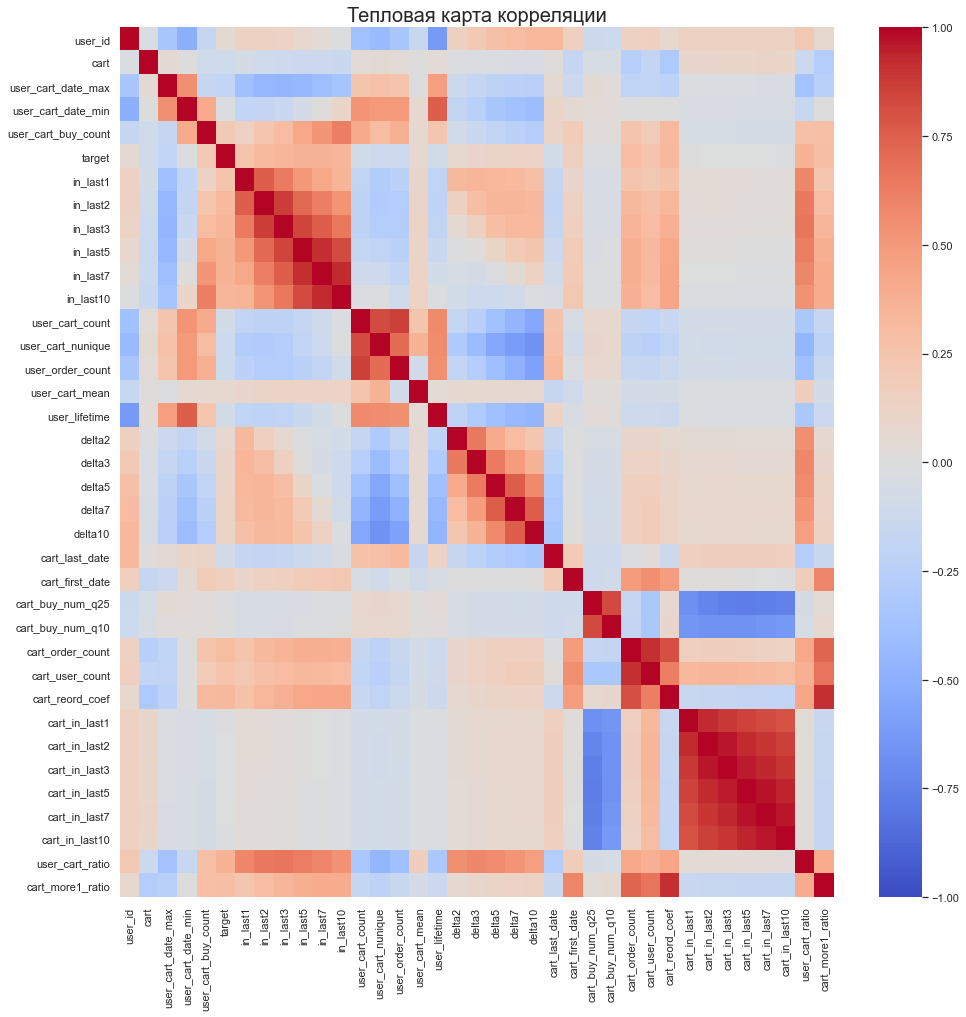

In [58]:
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(data_train.corr(), annot = False, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.title('Тепловая карта корреляции', fontsize=20);

In [59]:
#блок попарно получает значения корреляции и находит n наибольших

def get_red_pair(df):
    '''
    функция принимает df и возвращает множество пар признаков
    '''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_largest_correlations(df, n=30):
    '''
    функция принимает df и возвращает series с n наибольшими значениями 
    '''
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_red_pair(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

corr = get_largest_correlations(data_train)
print(corr)

cart_in_last5     cart_in_last7        0.972732
cart_in_last7     cart_in_last10       0.967919
cart_in_last2     cart_in_last3        0.963884
cart_in_last3     cart_in_last5        0.958572
cart_in_last5     cart_in_last10       0.939010
cart_in_last3     cart_in_last7        0.930379
in_last7          in_last10            0.929283
cart_in_last1     cart_in_last2        0.923895
cart_in_last2     cart_in_last5        0.923197
in_last5          in_last7             0.921249
cart_order_count  cart_user_count      0.908269
cart_reord_coef   cart_more1_ratio     0.907248
cart_in_last3     cart_in_last10       0.898209
cart_in_last2     cart_in_last7        0.895745
cart_in_last1     cart_in_last3        0.890029
in_last2          in_last3             0.867298
cart_in_last2     cart_in_last10       0.864886
user_cart_count   user_order_count     0.864812
cart_in_last1     cart_in_last5        0.852877
in_last3          in_last5             0.851301
cart_buy_num_q25  cart_buy_num_q10     0

### Списки признаков

In [60]:
# полный
feat_full = data_train.columns.tolist()
feat_full.remove('target')

# исключены категориальные 'user_id', 'cart' и неудачный 'cart_more1_ratio'
feat_full3 = data_train.columns.tolist()
for col in ['target', 'user_id', 'cart', 'cart_more1_ratio']:
    feat_full3.remove(col)

feat_full2 = feat_full3.copy()
for col in ['user_cart_ratio']:
    feat_full2.remove(col)

# короткий
feat_xs = ['user_id', 'cart', 'user_cart_date_max', 'user_cart_date_min', 'in_last1', 'in_last3', 'user_lifetime',
           'delta2', 'cart_reord_coef', 'user_cart_ratio']

# исключены коррелирующие признаки
feat_smart = ['user_cart_date_max', 'user_cart_date_min', 'user_cart_buy_count', 'in_last1', 'in_last2', 'in_last5', 
              'user_cart_count', 'user_order_count', 'user_cart_mean', 'delta2', 'delta5', 'cart_last_date', 
              'cart_first_date', 'cart_buy_num_q25', 'cart_buy_num_q10', 'cart_reord_coef', 'cart_in_last1', 
              'cart_in_last2', 'cart_in_last10']

feat_smart2 = ['user_cart_date_max', 'user_cart_date_min', 'user_cart_buy_count', 'in_last1', 'in_last2', 'in_last5', 
              'user_cart_count', 'user_order_count', 'user_cart_mean', 'delta2', 'delta5', 'cart_last_date', 
              'cart_first_date', 'cart_buy_num_q25', 'cart_buy_num_q10', 'cart_reord_coef', 'cart_in_last1', 
              'cart_in_last2', 'cart_in_last10', 'user_cart_ratio']

feat_smart2_cat = ['user_id', 'cart',
              'user_cart_date_max', 'user_cart_date_min', 'user_cart_buy_count', 'in_last1', 'in_last2', 'in_last5', 
              'user_cart_count', 'user_order_count', 'user_cart_mean', 'delta2', 'delta5', 'cart_last_date', 
              'cart_first_date', 'cart_buy_num_q25', 'cart_buy_num_q10', 'cart_reord_coef', 'cart_in_last1', 
              'cart_in_last2', 'cart_in_last10', 'user_cart_ratio']

# 10 признаков
feat_10 = ['in_last5', 'cart_reord_coef', 'in_last1', 'user_cart_buy_count', 'delta10', 'cart_buy_num_q25', 
           'cart_last_date', 'user_cart_nunique', 'user_order_count', 'user_cart_date_max']

# 20 признаков
feat_20 = ['cart_reord_coef','cart_order_count','cart_user_count', 'in_last10','user_cart_nunique', 
           'user_cart_date_max', 'user_cart_mean', 'user_order_count', 'in_last1', 'user_cart_buy_count', 
           'delta10', 'user_cart_date_min', 'user_cart_count', 'cart_buy_num_q10', 'user_id', 'cart_first_date', 
           'cart_in_last1', 'cart_in_last10', 'user_lifetime', 'cart_last_date']

# варианты с разными наборами "исторических" признаков
feat_1_2_5_10 = feat_full.copy()
for col in ['in_last3', 'in_last7','delta3', 'delta7', 'cart_in_last3', 'cart_in_last7', 'user_cart_ratio', 'cart_more1_ratio']:
    feat_1_2_5_10.remove(col)

feat_1_2_10 = feat_full.copy()
for col in ['in_last3', 'in_last5', 'in_last7','delta3', 'delta5','delta7', 'cart_in_last3', 'cart_in_last5', 'cart_in_last7']:
    feat_1_2_10.remove(col)

feat_1_2 = feat_1_2_10.copy()
for col in ['in_last10','delta10', 'cart_in_last10']:
    feat_1_2.remove(col)

feat_1_10 = feat_1_2_10.copy()
for col in ['in_last2','delta2', 'cart_in_last2']:
    feat_1_10.remove(col)
    
feat_list = [feat_full3, feat_xs, feat_smart2, feat_20, feat_10, feat_1_2_5_10] 
#feat_list = [feat_full3, feat_1_2_5_10] 
#feat_list = [feat_full3, feat_smart2] 
#feat_list = [feat_xs] 

feat_name_list = ['feat_full3', 'feat_xs', 'feat_smart2', 'feat_20', 'feat_10', 'feat_1_2_5_10'] 
#feat_name_list = ['feat_1_2_5_10']
#feat_name_list = ['feat_full3', 'feat_smart2'] 
#feat_name_list = ['feat_xs']

В связи с большим количеством вариантов в категориальных признаках('user_id', 'cart') их использование вероятно будет "вредить" моделям.

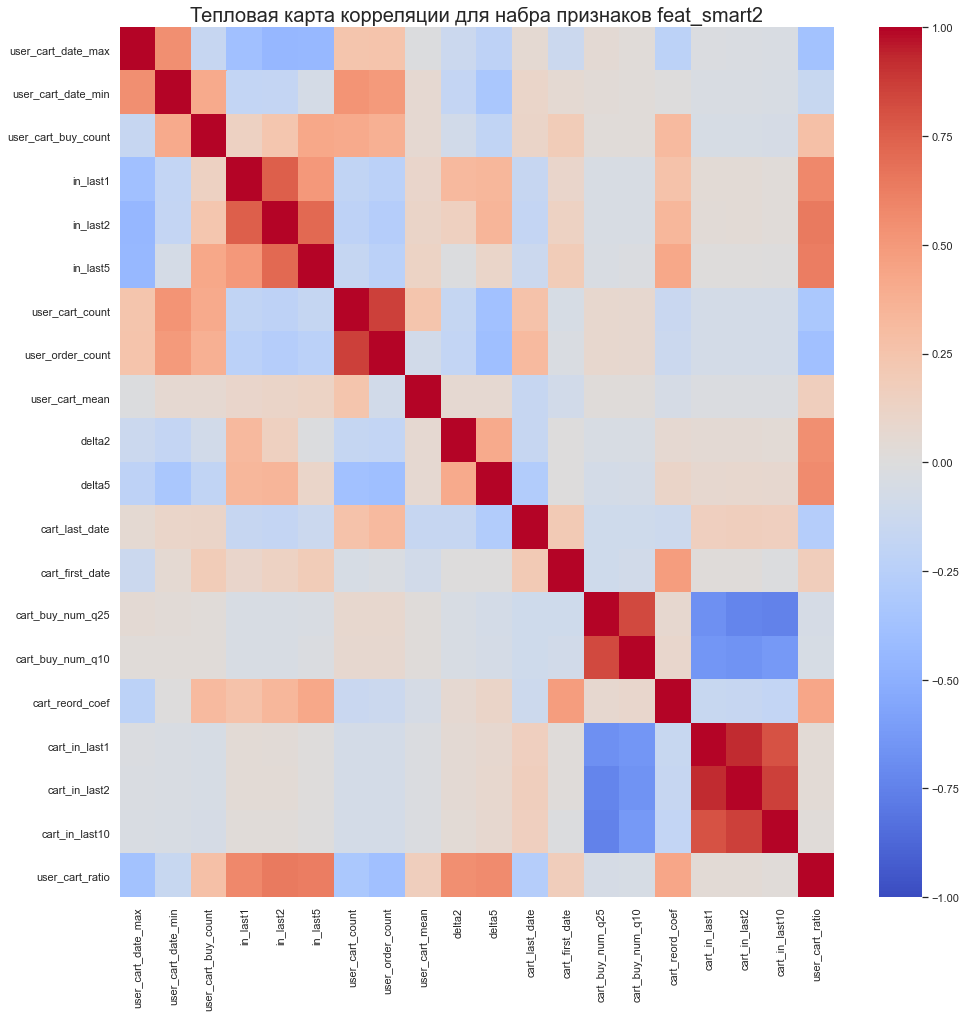

In [61]:
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(data_train[feat_smart2].corr(), annot = False, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.title('Тепловая карта корреляции для набра признаков feat_smart2', fontsize=20);

## Выбор модели
Задача - выбрать для финального обучения:
* модель
* группу признаков
* "глубину" (сколько последних продаж каждого клиента использовать для обучения)
* вариант обучающих строк (полный/отфильтрованный)
* гиперпараметры
* порог вероятности для определения классов 0/1

При обучении моделей можно использовать данные о покупках разной "глубины". Т.е. формировать признаки для одного, двух и т.д. последних заказах покупателя.

В финальной таблице указаны метрики моделей, обученных на третьей и девяти более ранних покупках (таргет - наличие во 2 и соотв. более ранних покупках). Валидация по прогнозу на признаках для 2 покупки и таргету (наличие в 1 покупке).

Результаты для другой "глубины" представлены в текстовых ячейках.

### Простой прогноз на основании последнего заказа
Самый простой вариант - предсказать по правилу был в последнем заказе - будет в следующем.

In [62]:
model_dict={} #словарь для данных по модели
b={}
b['model_name'] = 'Last1_dummy'
b['test_f1'] = f1_score(data_test['target'], data_test['in_last1'])
b['test_similar_f1'] = f1_score(data_test_similar['target'], data_test_similar['in_last1'])
model_dict[0] = b

final_table = pd.DataFrame(model_dict).T

In [63]:
final_table

,model_name,test_f1,test_similar_f1
0,Last1_dummy,0.40065,0.396803


In [64]:
sample_sub['user_id'] = sample_sub['user_id'].astype('int64')
sample_sub['cart'] = sample_sub['cart'].astype('int64')

last1_sub = sample_sub.merge(df_target, how='left', on=['user_id', 'cart']).fillna(0)
last1_sub['target'] = last1_sub['reverse_buy_num'].astype('int64')
last1_sub = last1_sub.loc[:, ['id', 'target']]
last1_sub = last1_sub.set_index(['id'])
last1_sub.to_csv('last1_sub.csv')
last1_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 790449 entries, 0;133 to 19998;415
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   target  790449 non-null  int64
dtypes: int64(1)
memory usage: 12.1+ MB


In [65]:
sample_sub['user_id'] = sample_sub['user_id'].astype('int64')
sample_sub['cart'] = sample_sub['cart'].astype('int64')

last1_sub = sample_sub.merge(df_target, how='left', on=['user_id', 'cart']).fillna(0)
last1_sub['target'] = last1_sub['reverse_buy_num'].astype('int64')
last1_sub = last1_sub.loc[:, ['id', 'target']]
last1_sub = last1_sub.set_index(['id'])
last1_sub.to_csv('last1_sub.csv')
last1_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 790449 entries, 0;133 to 19998;415
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   target  790449 non-null  int64
dtypes: int64(1)
memory usage: 12.1+ MB


### LogisticRegression

In [66]:
scaler = StandardScaler() #масштабируем признаки

model_dict={}   #словарь для данных по модели
i=0

for feat in feat_list:
    
    model = LogisticRegression(class_weight='balanced')
    b={}    
    b['model_name'] = 'LogisticRegression'
    b['feat_name'] = feat_name_list[i]
    
    # полный трейн / отфильтрованный тест 
    scaler.fit(data_train_1[feat])
    features_train = data_train_1[feat].copy()
    features_train = scaler.transform(features_train)
    target_train = data_train_1['target']
    features_test = data_test_similar[feat].copy() #data_test[feat].copy()
    features_test = scaler.transform(features_test)
    target_test = data_test_similar['target'] #data_test['target']
    
    model.fit(features_train, target_train)
    model_predicted = model.predict(features_test)
    b['test_f1'] = f1_score(target_test, model_predicted)
    
    # отфильтрованный трейн/тест (data_train_similar, data_test_similar)
    scaler.fit(data_train_1_similar[feat])
    features_train = data_train_1_similar[feat].copy()
    features_train = scaler.transform(features_train)
    target_train = data_train_1_similar['target']
    features_test = data_test_similar[feat].copy()
    features_test = scaler.transform(features_test)
    target_test = data_test_similar['target']
    
    model.fit(features_train, target_train)
    model_predicted = model.predict(features_test)
    b['test_similar_f1'] = f1_score(target_test, model_predicted)    
    
    model_dict[i] = b

    print(b['model_name'], 'test f1:%.4f' %b['test_f1'], 'test_similar f1:%.4f' %b['test_similar_f1'],
          'train_on_count:', cut_num-1, b['feat_name'])
    i+=1
    
final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=False)

LogisticRegression test f1:0.4902 test_similar f1:0.4855 train_on_count: 10 feat_full3
LogisticRegression test f1:0.4863 test_similar f1:0.4831 train_on_count: 10 feat_xs
LogisticRegression test f1:0.4907 test_similar f1:0.4885 train_on_count: 10 feat_smart2
LogisticRegression test f1:0.4851 test_similar f1:0.4817 train_on_count: 10 feat_20
LogisticRegression test f1:0.4829 test_similar f1:0.4822 train_on_count: 10 feat_10
LogisticRegression test f1:0.4875 test_similar f1:0.4828 train_on_count: 10 feat_1_2_5_10


In [68]:
final_table

,model_name,test_f1,test_similar_f1,feat_name
0,Last1_dummy,0.40065,0.396803,NaN
0,LogisticRegression,0.490197,0.485494,feat_full3
1,LogisticRegression,0.486313,0.483112,feat_xs
2,LogisticRegression,0.490735,0.488538,feat_smart2
3,LogisticRegression,0.485079,0.481654,feat_20
4,LogisticRegression,0.48295,0.482225,feat_10
5,LogisticRegression,0.487543,0.482842,feat_1_2_5_10
0,LogisticRegression,0.490197,0.485494,feat_full3
1,LogisticRegression,0.486313,0.483112,feat_xs
2,LogisticRegression,0.490735,0.488538,feat_smart2


#### Результаты LR

**глубина - 1 последний заказ**
* LogisticRegression test f1:0.4902 test_similar f1:0.4855 train_on_count: 1 feat_full3
* LogisticRegression test f1:0.4863 test_similar f1:0.4831 train_on_count: 1 feat_xs
* LogisticRegression **test f1:0.4907** test_similar f1:0.4885 train_on_count: 1 feat_smart2
* LogisticRegression test f1:0.4851 test_similar f1:0.4817 train_on_count: 1 feat_20
* LogisticRegression test f1:0.4829 test_similar f1:0.4822 train_on_count: 1 feat_10
* LogisticRegression test f1:0.4875 test_similar f1:0.4828 train_on_count: 1 feat_1_2_5_10

**глубина - 2 последних заказа**
* LogisticRegression test f1:0.4890 test_similar f1:0.4694 train_on_count: 2 feat_full3
* LogisticRegression test f1:0.4873 test_similar f1:0.4869 train_on_count: 2 feat_xs
* LogisticRegression test f1:0.4905 test_similar f1:0.4839 train_on_count: 2 feat_smart2
* LogisticRegression test f1:0.4848 test_similar f1:0.4650 train_on_count: 2 feat_20
* LogisticRegression test f1:0.4837 test_similar f1:0.4826 train_on_count: 2 feat_10

**глубина - 5 последних заказов**
* LogisticRegression test f1:0.4836 test_similar f1:0.4763 train_on_count: 5 feat_full3
* LogisticRegression test f1:0.4891 test_similar f1:0.4861 train_on_count: 5 feat_xs
* LogisticRegression test f1:0.4895 test_similar f1:0.4854 train_on_count: 5 feat_smart2
* LogisticRegression test f1:0.4788 test_similar f1:0.4730 train_on_count: 5 feat_20
* LogisticRegression test f1:0.4835 test_similar f1:0.4832 train_on_count: 5 feat_10
* LogisticRegression test f1:0.4798 test_similar f1:0.4731 train_on_count: 5 feat_1_2_5_10

**глубина - 10 последних заказов**
* LogisticRegression test f1:0.4774 test_similar f1:0.4694 train_on_count: 10 feat_full3
* LogisticRegression test f1:0.4899 test_similar f1:0.4869 train_on_count: 10 feat_xs
* LogisticRegression test f1:0.4888 test_similar f1:0.4839 train_on_count: 10 feat_smart2
* LogisticRegression test f1:0.4824 test_similar f1:0.4826 train_on_count: 10 feat_10
* LogisticRegression test f1:0.4737 test_similar f1:0.4662 train_on_count: 10 feat_1_2_5_10

#### Выбор порога LR
Для лучшего набора признаков (feat_smart2), лучшей "глубины" (данные об одном последнем заказе покупателей) найдем оптимальные пороги.

In [69]:
model_dict={}
b={}    
b['model_name'] = 'LogisticRegression'
b['feat_name'] = 'feat_smart2'

#полный трейн
scaler.fit(data_train_1[feat_smart2])
features_train = data_train_1[feat_smart2].copy()
features_train = scaler.transform(features_train)
target_train = data_train_1['target']
features_test = data_test_similar[feat_smart2].copy()
features_test = scaler.transform(features_test)
target_test = data_test_similar['target']

model.fit(features_train, target_train)
model_proba = model.predict_proba(features_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(target_test, model_proba)
numerator = 2 * recall * precision
denom = recall + precision
f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
b['test_f1'] = np.max(f1_scores)
b['threshold'] = thresholds[np.argmax(f1_scores)]
model_dict[0]=b

print('max f1:', b['test_f1'], 'max f1 threshold:', b['threshold'])

final_table = pd.concat([final_table, pd.DataFrame(model_dict).T])

max f1: 0.4917811394535542 max f1 threshold: 0.5165633224901034


In [70]:
model_dict={}
b={}    
b['model_name'] = 'LogisticRegression'
b['feat_name'] = 'feat_smart2'

#урезанный трейн
scaler.fit(data_train_1_similar[feat_smart2])
features_train = data_train_1_similar[feat_smart2].copy()
features_train = scaler.transform(features_train)
target_train = data_train_1_similar['target']
features_test = data_test_similar[feat_smart2].copy()
features_test = scaler.transform(features_test)
target_test = data_test_similar['target']

model.fit(features_train, target_train)
model_proba = model.predict_proba(features_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(target_test, model_proba)
numerator = 2 * recall * precision
denom = recall + precision
f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
b['test_similar_f1'] = np.max(f1_scores)
b['threshold'] = thresholds[np.argmax(f1_scores)]
model_dict[0]=b

print('max similar_f1:', b['test_similar_f1'], 'max f1 threshold:', b['threshold'])

mod_coef = abs(model.coef_.ravel())
# индексированные названием признака веса
rcoef = pd.Series(np.std(features_train, 0)*mod_coef/mod_coef.sum(), index=feat_smart2)

final_table = pd.concat([final_table, pd.DataFrame(model_dict).T])

max similar_f1: 0.4923154947545637 max f1 threshold: 0.5567368208596931


In [71]:
final_table

,model_name,test_f1,test_similar_f1,feat_name,threshold
0,Last1_dummy,0.40065,0.396803,NaN,NaN
0,LogisticRegression,0.490197,0.485494,feat_full3,NaN
1,LogisticRegression,0.486313,0.483112,feat_xs,NaN
2,LogisticRegression,0.490735,0.488538,feat_smart2,NaN
3,LogisticRegression,0.485079,0.481654,feat_20,NaN
4,LogisticRegression,0.48295,0.482225,feat_10,NaN
5,LogisticRegression,0.487543,0.482842,feat_1_2_5_10,NaN
0,LogisticRegression,0.490197,0.485494,feat_full3,NaN
1,LogisticRegression,0.486313,0.483112,feat_xs,NaN
2,LogisticRegression,0.490735,0.488538,feat_smart2,NaN


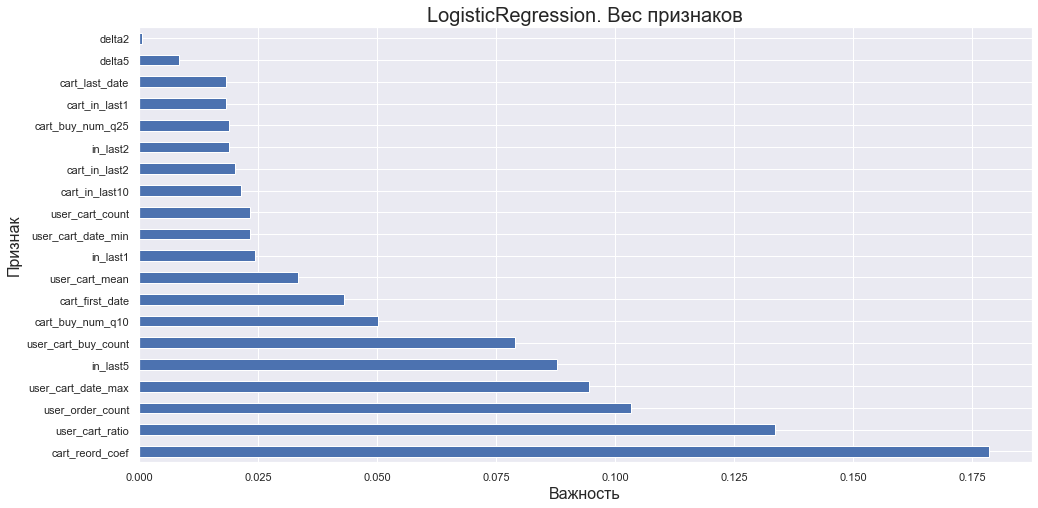

In [72]:
rcoef.nlargest(20).plot(kind='barh', figsize=(16, 8))
plt.title('LogisticRegression. Вес признаков', fontsize=20)
plt.ylabel('Признак', fontsize=16)
plt.xlabel('Важность', fontsize=16);

#### Выводы по LR
* Результаты заметно выше "простого прогноза"
* LR, лучше обучать на данных глубиной 1 (одна последняя покупка для каждой пары покупатель/категория)
* Лучшие результаты для набора признаков: feat_smart2
* Полный набор строк (неурезанный по условию) показал себя лучше 

### LGBMClassifier

#### OPTUNA Поиск параметров с максимальным значением roc_auc_score
Наиболее перспективные наборы признаков: feat_full3 и feat_smart2. Для них и буду подбирать гиперпараметры.

In [73]:
feat_list = [feat_full3, feat_smart2] 
feat_name_list = ['feat_full3', 'feat_smart2'] 

In [74]:
# Подбор параметров optuna roc_auc_score data_train_similar

def objective(trial):
    
    features_train = data_train_similar[feat].values
    target_train = data_train_similar['target'].values.ravel()
    features_test = data_test_similar[feat].values #data_test[feat].copy()
    target_test = data_test_similar['target'].values.ravel() #data_test['target']
       
    param = {
        'objective': 'binary',
        'class_weight': 'balanced',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'lambda_l2': trial.suggest_int('lambda_l2', 1, 12),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 100),
        'n_estimators': trial.suggest_int('n_estimators', 101, 301, 10),
        'max_depth': trial.suggest_int('max_depth', 20, 90)
    }
    
    model = LGBMClassifier(**param)
    
    model.fit(features_train,
              target_train,
              eval_set=(features_test, target_test),
              early_stopping_rounds=50,
              eval_metric='roc_auc_score')
    
    preds_prob_1 = model.predict_proba(features_test)[:, 1]
    auc = roc_auc_score(target_test, preds_prob_1)
    return auc

i=0
model_dict={}
print('cut_num:', cut_num)

for feat in feat_list:
    
    b={}
    b['model_name'] = 'LGBMClassifier'
    b['feat_name'] = feat_name_list[i]
    print('cut_num:', cut_num)
    print(b['feat_name'])

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=2) #100
    b['params'] =  study.best_params
    b['best_value'] = study.best_value
    print(b['best_value'], b['model_name'], b['feat_name'], 'cut_num:', cut_num)
    print(b['params'])
    model_dict[i] = b
    i+=1

    
optuna_table = pd.DataFrame(model_dict).T
optuna_table

[I 2021-12-31 12:28:34,670] A new study created in memory with name: no-name-66df718b-1e19-4319-8969-21529b9a8cf4


cut_num: 11
cut_num: 11
feat_full3
[LightGBM] [Warning] min_data_in_leaf is set=733, min_child_samples=42 will be ignored. Current value: min_data_in_leaf=733
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[1]	valid_0's binary_logloss: 0.671061
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.652473
[3]	valid_0's binary_logloss: 0.636875
[4]	valid_0's binary_logloss: 0.624291
[5]	valid_0's binary_logloss: 0.613306
[6]	valid_0's binary_logloss: 0.604475
[7]	valid_0's binary_logloss: 0.596692
[8]	valid_0's binary_logloss: 0.590311
[9]	valid_0's binary_logloss: 0.584784
[10]	valid_0's binary_logloss: 0.580259
[11]	valid_0's binary_logloss: 0.57618
[12]	valid_0's binary_logloss: 0.572836
[13]	valid_0's binary_logloss: 0.569955
[14]	valid_0's binary_logloss: 0.567271
[15]	valid_0's binary_logloss: 0.564995
[16]	valid_0's binary_logloss: 0.563313
[17]	valid_0's binary_logloss: 0.561878
[18]	val

[197]	valid_0's binary_logloss: 0.537097
[198]	valid_0's binary_logloss: 0.537126
[199]	valid_0's binary_logloss: 0.537068
[200]	valid_0's binary_logloss: 0.537057
[201]	valid_0's binary_logloss: 0.537042
[202]	valid_0's binary_logloss: 0.536959
[203]	valid_0's binary_logloss: 0.536953
[204]	valid_0's binary_logloss: 0.53691
[205]	valid_0's binary_logloss: 0.536873
[206]	valid_0's binary_logloss: 0.536866
[207]	valid_0's binary_logloss: 0.536672
[208]	valid_0's binary_logloss: 0.536625
[209]	valid_0's binary_logloss: 0.53662
[210]	valid_0's binary_logloss: 0.536143
[211]	valid_0's binary_logloss: 0.536139
[212]	valid_0's binary_logloss: 0.536122
[213]	valid_0's binary_logloss: 0.536102
[214]	valid_0's binary_logloss: 0.536051
[215]	valid_0's binary_logloss: 0.536048
[216]	valid_0's binary_logloss: 0.536027
[217]	valid_0's binary_logloss: 0.53596
[218]	valid_0's binary_logloss: 0.535929
[219]	valid_0's binary_logloss: 0.535935
[220]	valid_0's binary_logloss: 0.53536
[221]	valid_0's bina

[I 2021-12-31 12:33:56,539] Trial 0 finished with value: 0.7944538832402168 and parameters: {'learning_rate': 0.09768012734663852, 'lambda_l2': 12, 'num_leaves': 188, 'min_data_in_leaf': 733, 'min_child_samples': 42, 'n_estimators': 241, 'max_depth': 60}. Best is trial 0 with value: 0.7944538832402168.


[LightGBM] [Warning] min_data_in_leaf is set=207, min_child_samples=91 will be ignored. Current value: min_data_in_leaf=207
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[1]	valid_0's binary_logloss: 0.688085
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.682921
[3]	valid_0's binary_logloss: 0.67815
[4]	valid_0's binary_logloss: 0.673749
[5]	valid_0's binary_logloss: 0.669326
[6]	valid_0's binary_logloss: 0.664987
[7]	valid_0's binary_logloss: 0.661067
[8]	valid_0's binary_logloss: 0.657383
[9]	valid_0's binary_logloss: 0.65366
[10]	valid_0's binary_logloss: 0.650378
[11]	valid_0's binary_logloss: 0.64692
[12]	valid_0's binary_logloss: 0.643984
[13]	valid_0's binary_logloss: 0.640608
[14]	valid_0's binary_logloss: 0.637897
[15]	valid_0's binary_logloss: 0.634782
[16]	valid_0's binary_logloss: 0.632287
[17]	valid_0's binary_logloss: 0.629411
[18]	valid_0's binary_logloss: 0.62714
[19]	val

[198]	valid_0's binary_logloss: 0.553868
[199]	valid_0's binary_logloss: 0.553845
[200]	valid_0's binary_logloss: 0.553819
[201]	valid_0's binary_logloss: 0.553829
[202]	valid_0's binary_logloss: 0.553838
[203]	valid_0's binary_logloss: 0.55373
[204]	valid_0's binary_logloss: 0.553784
[205]	valid_0's binary_logloss: 0.553668
[206]	valid_0's binary_logloss: 0.553679
[207]	valid_0's binary_logloss: 0.553678
[208]	valid_0's binary_logloss: 0.553611
[209]	valid_0's binary_logloss: 0.553484
[210]	valid_0's binary_logloss: 0.553526
[211]	valid_0's binary_logloss: 0.553425
[212]	valid_0's binary_logloss: 0.55349
[213]	valid_0's binary_logloss: 0.553523
[214]	valid_0's binary_logloss: 0.553528
[215]	valid_0's binary_logloss: 0.553476
[216]	valid_0's binary_logloss: 0.553496
[217]	valid_0's binary_logloss: 0.553485
[218]	valid_0's binary_logloss: 0.553419
[219]	valid_0's binary_logloss: 0.553446
[220]	valid_0's binary_logloss: 0.553451
[221]	valid_0's binary_logloss: 0.553473
[222]	valid_0's bi

[I 2021-12-31 12:38:48,841] Trial 1 finished with value: 0.7942726623325674 and parameters: {'learning_rate': 0.02285704250643435, 'lambda_l2': 2, 'num_leaves': 14, 'min_data_in_leaf': 207, 'min_child_samples': 91, 'n_estimators': 261, 'max_depth': 21}. Best is trial 0 with value: 0.7944538832402168.


[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=88 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[1]	valid_0's binary_logloss: 0.676704
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.662383
[3]	valid_0's binary_logloss: 0.649649
[4]	valid_0's binary_logloss: 0.638758
[5]	valid_0's binary_logloss: 0.628699
[6]	valid_0's binary_logloss: 0.620342
[7]	valid_0's binary_logloss: 0.612815
[8]	valid_0's binary_logloss: 0.606039
[9]	valid_0's binary_logloss: 0.600107
[10]	valid_0's binary_logloss: 0.594872
[11]	valid_0's binary_logloss: 0.590256
[12]	valid_0's binary_logloss: 0.586175
[13]	valid_0's binary_logloss: 0.582524
[14]	valid_0's binary_logloss: 0.579112
[15]	valid_0's binary_logloss: 0.576129
[16]	valid_0's binary_logloss: 0.573654
[17]	valid_0's binary_logloss: 0.571282
[18]	valid_0's binary_logloss: 0.569164
[19]	v

[I 2021-12-31 12:42:27,424] Trial 2 finished with value: 0.7955664770223332 and parameters: {'learning_rate': 0.07153709206792316, 'lambda_l2': 1, 'num_leaves': 200, 'min_data_in_leaf': 88, 'min_child_samples': 88, 'n_estimators': 131, 'max_depth': 83}. Best is trial 2 with value: 0.7955664770223332.


[LightGBM] [Warning] min_data_in_leaf is set=616, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=616
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[1]	valid_0's binary_logloss: 0.675266
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.659637
[3]	valid_0's binary_logloss: 0.645913
[4]	valid_0's binary_logloss: 0.634501
[5]	valid_0's binary_logloss: 0.624315
[6]	valid_0's binary_logloss: 0.615589
[7]	valid_0's binary_logloss: 0.607811
[8]	valid_0's binary_logloss: 0.601124
[9]	valid_0's binary_logloss: 0.595365
[10]	valid_0's binary_logloss: 0.590263
[11]	valid_0's binary_logloss: 0.585921
[12]	valid_0's binary_logloss: 0.581985
[13]	valid_0's binary_logloss: 0.578482
[14]	valid_0's binary_logloss: 0.575557
[15]	valid_0's binary_logloss: 0.572747
[16]	valid_0's binary_logloss: 0.570445
[17]	valid_0's binary_logloss: 0.568445
[18]	valid_0's binary_logloss: 0.56647
[19

[I 2021-12-31 12:46:30,283] Trial 3 finished with value: 0.795313861474323 and parameters: {'learning_rate': 0.0785525339307668, 'lambda_l2': 10, 'num_leaves': 175, 'min_data_in_leaf': 616, 'min_child_samples': 11, 'n_estimators': 161, 'max_depth': 78}. Best is trial 2 with value: 0.7955664770223332.


[LightGBM] [Warning] min_data_in_leaf is set=67, min_child_samples=84 will be ignored. Current value: min_data_in_leaf=67
[LightGBM] [Warning] lambda_l2 is set=8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8
[1]	valid_0's binary_logloss: 0.687877
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.682629
[3]	valid_0's binary_logloss: 0.67753
[4]	valid_0's binary_logloss: 0.672833
[5]	valid_0's binary_logloss: 0.668425
[6]	valid_0's binary_logloss: 0.664063
[7]	valid_0's binary_logloss: 0.659812
[8]	valid_0's binary_logloss: 0.655818
[9]	valid_0's binary_logloss: 0.652003
[10]	valid_0's binary_logloss: 0.648134
[11]	valid_0's binary_logloss: 0.644631
[12]	valid_0's binary_logloss: 0.641117
[13]	valid_0's binary_logloss: 0.637793
[14]	valid_0's binary_logloss: 0.634655
[15]	valid_0's binary_logloss: 0.631649
[16]	valid_0's binary_logloss: 0.628753
[17]	valid_0's binary_logloss: 0.626145
[18]	valid_0's binary_logloss: 0.623408
[19]	va

[I 2021-12-31 12:50:41,198] Trial 4 finished with value: 0.7947389611248457 and parameters: {'learning_rate': 0.02301013212001254, 'lambda_l2': 8, 'num_leaves': 46, 'min_data_in_leaf': 67, 'min_child_samples': 84, 'n_estimators': 161, 'max_depth': 74}. Best is trial 2 with value: 0.7955664770223332.


[LightGBM] [Warning] min_data_in_leaf is set=751, min_child_samples=80 will be ignored. Current value: min_data_in_leaf=751
[LightGBM] [Warning] lambda_l2 is set=6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6
[1]	valid_0's binary_logloss: 0.680995
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.669716
[3]	valid_0's binary_logloss: 0.658772
[4]	valid_0's binary_logloss: 0.649394
[5]	valid_0's binary_logloss: 0.641082
[6]	valid_0's binary_logloss: 0.634012
[7]	valid_0's binary_logloss: 0.626539
[8]	valid_0's binary_logloss: 0.621206
[9]	valid_0's binary_logloss: 0.615062
[10]	valid_0's binary_logloss: 0.609859
[11]	valid_0's binary_logloss: 0.605047
[12]	valid_0's binary_logloss: 0.601075
[13]	valid_0's binary_logloss: 0.596882
[14]	valid_0's binary_logloss: 0.593995
[15]	valid_0's binary_logloss: 0.591183
[16]	valid_0's binary_logloss: 0.587753
[17]	valid_0's binary_logloss: 0.585442
[18]	valid_0's binary_logloss: 0.582658
[19]

[197]	valid_0's binary_logloss: 0.548364
[198]	valid_0's binary_logloss: 0.548343
[199]	valid_0's binary_logloss: 0.548361
[200]	valid_0's binary_logloss: 0.548339
[201]	valid_0's binary_logloss: 0.548322
[202]	valid_0's binary_logloss: 0.548188
[203]	valid_0's binary_logloss: 0.548186
[204]	valid_0's binary_logloss: 0.548184
[205]	valid_0's binary_logloss: 0.548183
[206]	valid_0's binary_logloss: 0.548132
[207]	valid_0's binary_logloss: 0.547927
[208]	valid_0's binary_logloss: 0.547897
[209]	valid_0's binary_logloss: 0.547943
[210]	valid_0's binary_logloss: 0.547917
[211]	valid_0's binary_logloss: 0.547901
Did not meet early stopping. Best iteration is:
[208]	valid_0's binary_logloss: 0.547897


[I 2021-12-31 12:54:51,650] Trial 5 finished with value: 0.7957309198382589 and parameters: {'learning_rate': 0.05580808108267083, 'lambda_l2': 6, 'num_leaves': 25, 'min_data_in_leaf': 751, 'min_child_samples': 80, 'n_estimators': 211, 'max_depth': 84}. Best is trial 5 with value: 0.7957309198382589.


[LightGBM] [Warning] min_data_in_leaf is set=624, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=624
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[1]	valid_0's binary_logloss: 0.68677
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.680189
[3]	valid_0's binary_logloss: 0.674385
[4]	valid_0's binary_logloss: 0.668778
[5]	valid_0's binary_logloss: 0.663316
[6]	valid_0's binary_logloss: 0.658283
[7]	valid_0's binary_logloss: 0.6534
[8]	valid_0's binary_logloss: 0.64856
[9]	valid_0's binary_logloss: 0.644431
[10]	valid_0's binary_logloss: 0.64027
[11]	valid_0's binary_logloss: 0.636825
[12]	valid_0's binary_logloss: 0.632828
[13]	valid_0's binary_logloss: 0.629745
[14]	valid_0's binary_logloss: 0.626244
[15]	valid_0's binary_logloss: 0.623466
[16]	valid_0's binary_logloss: 0.620186
[17]	valid_0's binary_logloss: 0.61761
[18]	valid_0's binary_logloss: 0.615
[19]	valid_0'

[I 2021-12-31 12:58:47,016] Trial 6 finished with value: 0.794528754035708 and parameters: {'learning_rate': 0.029004058688073285, 'lambda_l2': 5, 'num_leaves': 18, 'min_data_in_leaf': 624, 'min_child_samples': 11, 'n_estimators': 171, 'max_depth': 65}. Best is trial 5 with value: 0.7957309198382589.


[LightGBM] [Warning] min_data_in_leaf is set=523, min_child_samples=19 will be ignored. Current value: min_data_in_leaf=523
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3


KeyboardInterrupt: 

#### Результаты OPTUNA

**feat_full3 5 продаж**
* Trial 55 finished with value: 0.7959899216187092 and parameters: {'learning_rate': 0.04813876328260051, 'lambda_l2': 12, 'num_leaves': 192, 'min_data_in_leaf': 883, 'min_child_samples': 84}
* Trial 26 finished with value: 0.7960492195065864 and parameters: {'learning_rate': 0.0303104129329263, 'lambda_l2': 7, 'num_leaves': 180, 'min_data_in_leaf': 722, 'min_child_samples': 41, 'n_estimators': 201, 'max_depth': 25

**feat_smart2 5 продаж**
* Trial 36 finished with value: 0.795513605586657 and parameters: {'learning_rate': 0.05640838553331615, 'lambda_l2': 9, 'num_leaves': 167, 'min_data_in_leaf': 682, 'min_child_samples': 21}
* Trial 40 finished with value: 0.7954802996272864 and parameters: {'learning_rate': 0.025214382061170958, 'lambda_l2': 1, 'num_leaves': 150, 'min_child_samples': 86, 'n_estimators': 211, 'max_depth': 71}
* Trial 81 finished with value: 0.7955498945619757 and parameters: {'learning_rate': 0.024980818038726052, 'lambda_l2': 2, 'num_leaves': 178, 'min_child_samples': 90, 'n_estimators': 211, 'max_depth': 44}

**feat_full3 10 продаж**
* Trial 53 finished with value: 0.7960340199853482 and parameters: {'learning_rate': 0.06255483118484784, 'lambda_l2': 6, 'num_leaves': 193, 'min_data_in_leaf': 395, 'min_child_samples': 87}
* Trial 31 finished with value: 0.7960267357987714 and parameters: {'learning_rate': 0.052781426663039345, 'lambda_l2': 8, 'num_leaves': 169, 'min_data_in_leaf': 562, 'min_child_samples': 82}
* Trial 61 finished with value: **0.796162549033449** and parameters: {'learning_rate': 0.02339831228126051, 'lambda_l2': 10, 'num_leaves': 194, 'min_data_in_leaf': 825, 'min_child_samples': 73, 'n_estimators': 301, 'max_depth': 67}

**feat_full3 10 продаж урезанный трейн**
* Trial 21 finished with value: **0.7961004678115484** and parameters: {'learning_rate': 0.017471330708542968, 'lambda_l2': 6, 'num_leaves': 196, 'min_data_in_leaf': 47, 'min_child_samples': 4, 'n_estimators': 301, 'max_depth': 72}

**feat_smart2 10 продаж**
* Trial 69 finished with value: 0.7955043191828094 and parameters: {'learning_rate': 0.06942368849666279, 'lambda_l2': 5, 'num_leaves': 167, 'min_data_in_leaf': 205, 'min_child_samples': 13}
* Trial 18 finished with value: 0.7955174648462372 and parameters: {'learning_rate': 0.03520100142206479, 'lambda_l2': 10, 'num_leaves': 158, 'min_data_in_leaf': 879, 'min_child_samples': 96, 'n_estimators': 171, 'max_depth': 20}


#### Выбор порога LGBM

In [75]:
#LGBM_1 полный трейн, набор параметров 1
print(feat_name_list)
print('cut_num:', cut_num)

model_dict={}   #словарь для данных по модели
i=0

for feat in feat_list:
    
    b={}
    b['model_name'] = 'LGBMClassifier_1'
    b['feat_name'] = feat_name_list[i]
    
    model = LGBMClassifier(class_weight='balanced',
                           objective='binary',
                           learning_rate=0.02339831228126051,
                           lambda_l2=10,
                           min_child_samples=73, 
                           num_leaves=194, 
                           min_data_in_leaf=825,
                           n_estimators=301,
                           max_depth=67)
    
    # полный трейн 
    features_train = data_train[feat].copy().values
    target_train = data_train['target'].values.ravel()
    features_test = data_test_similar[feat].copy().values #data_test[feat].copy()
    target_test = data_test_similar['target'].values.ravel() #data_test['target']
    
    model.fit(features_train, target_train)
    model_proba = model.predict_proba(features_test)[:, 1]
    
    #найдем попрог с максимальным f1
    precision, recall, thresholds = precision_recall_curve(target_test, model_proba)
    numerator = 2 * recall * precision
    denom = recall + precision
    f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
    b['test_f1'] = np.max(f1_scores)
    b['threshold'] = thresholds[np.argmax(f1_scores)]
    
    model_dict[i] = b
    
    i+=1

    print(b['model_name'], 'f1:%.4f' %b['test_f1'], 'cut_num:', cut_num, b['feat_name'], b['threshold'])


final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=False)
final_table

#cm = confusion_matrix(target_test.values.ravel(), model_predicted)

['feat_full3', 'feat_smart2']
cut_num: 11
LGBMClassifier_1 f1:0.4981 cut_num: 11 feat_full3 0.584820643923132
[LightGBM] [Warning] min_data_in_leaf is set=825, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=825
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
LGBMClassifier_1 f1:0.4972 cut_num: 11 feat_smart2 0.5561402906397446


,model_name,test_f1,test_similar_f1,feat_name,threshold
0,Last1_dummy,0.40065,0.396803,NaN,NaN
0,LogisticRegression,0.490197,0.485494,feat_full3,NaN
1,LogisticRegression,0.486313,0.483112,feat_xs,NaN
2,LogisticRegression,0.490735,0.488538,feat_smart2,NaN
3,LogisticRegression,0.485079,0.481654,feat_20,NaN
4,LogisticRegression,0.48295,0.482225,feat_10,NaN
5,LogisticRegression,0.487543,0.482842,feat_1_2_5_10,NaN
0,LogisticRegression,0.490197,0.485494,feat_full3,NaN
1,LogisticRegression,0.486313,0.483112,feat_xs,NaN
2,LogisticRegression,0.490735,0.488538,feat_smart2,NaN


In [76]:
#LGBM_2 урезанный трейн, набор параметров 1
print(feat_name_list)
print('cut_num:', cut_num)

model_dict={}   #словарь для данных по модели
i=0

for feat in feat_list:
    
    b={}
    b['model_name'] = 'LGBMClassifier_1'
    b['feat_name'] = feat_name_list[i]
    
    model = LGBMClassifier(class_weight='balanced',
                           objective='binary',
                           learning_rate=0.02339831228126051,
                           lambda_l2=10,
                           min_child_samples=73, 
                           num_leaves=194, 
                           min_data_in_leaf=825,
                           n_estimators=301,
                           max_depth=67)
    
    # отфильтрованный трейн 
    features_train = data_train_similar[feat].values
    target_train = data_train_similar['target'].values.ravel()
    features_test = data_test_similar[feat].values #data_test[feat].copy()
    target_test = data_test_similar['target'].values.ravel() #data_test['target']
    
    model.fit(features_train, target_train)
    model_proba = model.predict_proba(features_test)[:, 1]
    
    #найдем попрог с максимальным f1
    precision, recall, thresholds = precision_recall_curve(target_test, model_proba)
    numerator = 2 * recall * precision
    denom = recall + precision
    f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
    b['test_similar_f1'] = np.max(f1_scores)
    b['threshold'] = thresholds[np.argmax(f1_scores)]
    
    model_dict[i] = b
    
    i+=1

    print(b['model_name'], 'f1:%.4f' %b['test_similar_f1'], 'cut_num:', cut_num, b['feat_name'], b['threshold'])


final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=False)
final_table

['feat_full3', 'feat_smart2']
cut_num: 11
[LightGBM] [Warning] min_data_in_leaf is set=825, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=825
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
LGBMClassifier_1 f1:0.4983 cut_num: 11 feat_full3 0.5913174360262046
[LightGBM] [Warning] min_data_in_leaf is set=825, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=825
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
LGBMClassifier_1 f1:0.4974 cut_num: 11 feat_smart2 0.5829901991364094


,model_name,test_f1,test_similar_f1,feat_name,threshold
0,Last1_dummy,0.40065,0.396803,NaN,NaN
0,LogisticRegression,0.490197,0.485494,feat_full3,NaN
1,LogisticRegression,0.486313,0.483112,feat_xs,NaN
2,LogisticRegression,0.490735,0.488538,feat_smart2,NaN
3,LogisticRegression,0.485079,0.481654,feat_20,NaN
4,LogisticRegression,0.48295,0.482225,feat_10,NaN
5,LogisticRegression,0.487543,0.482842,feat_1_2_5_10,NaN
0,LogisticRegression,0.490197,0.485494,feat_full3,NaN
1,LogisticRegression,0.486313,0.483112,feat_xs,NaN
2,LogisticRegression,0.490735,0.488538,feat_smart2,NaN


In [77]:
#LGBM_3 полный трейн, набор параметров 2
print(feat_name_list)
print('cut_num:', cut_num)

model_dict={}   #словарь для данных по модели
i=0

for feat in feat_list:
    
    b={}
    b['model_name'] = 'LGBMClassifier_2'
    b['feat_name'] = feat_name_list[i]
    
    model = LGBMClassifier(class_weight='balanced',
                           objective='binary',
                           learning_rate=0.017471330708542968, 
                           lambda_l2=6, 
                           num_leaves=196, 
                           min_data_in_leaf=47, 
                           min_child_samples=4, 
                           n_estimators=301, 
                           max_depth=72)
    
    # полный трейн 
    features_train = data_train[feat].copy().values
    target_train = data_train['target'].values.ravel()
    features_test = data_test_similar[feat].copy().values #data_test[feat].copy()
    target_test = data_test_similar['target'].values.ravel() #data_test['target']
    
    model.fit(features_train, target_train)
    model_proba = model.predict_proba(features_test)[:, 1]
    
    #найдем попрог с максимальным f1
    precision, recall, thresholds = precision_recall_curve(target_test, model_proba)
    numerator = 2 * recall * precision
    denom = recall + precision
    f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
    b['test_f1'] = np.max(f1_scores)
    b['threshold'] = thresholds[np.argmax(f1_scores)]
    
    model_dict[i] = b
    
    i+=1

    print(b['model_name'], 'f1:%.4f' %b['test_f1'], 'cut_num:', cut_num, b['feat_name'], b['threshold'])


final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=False)
final_table

['feat_full3', 'feat_smart2']
cut_num: 11
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] lambda_l2 is set=6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6
LGBMClassifier_2 f1:0.4980 cut_num: 11 feat_full3 0.5779881653763397
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] lambda_l2 is set=6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6
LGBMClassifier_2 f1:0.4971 cut_num: 11 feat_smart2 0.5474653562406843


,model_name,test_f1,test_similar_f1,feat_name,threshold
0,Last1_dummy,0.40065,0.396803,NaN,NaN
0,LogisticRegression,0.490197,0.485494,feat_full3,NaN
1,LogisticRegression,0.486313,0.483112,feat_xs,NaN
2,LogisticRegression,0.490735,0.488538,feat_smart2,NaN
3,LogisticRegression,0.485079,0.481654,feat_20,NaN
4,LogisticRegression,0.48295,0.482225,feat_10,NaN
5,LogisticRegression,0.487543,0.482842,feat_1_2_5_10,NaN
0,LogisticRegression,0.490197,0.485494,feat_full3,NaN
1,LogisticRegression,0.486313,0.483112,feat_xs,NaN
2,LogisticRegression,0.490735,0.488538,feat_smart2,NaN


In [78]:
##LGBM_4 урезанный трейн, набор параметров 2
print(feat_name_list)
print('cut_num:', cut_num)

model_dict={}   #словарь для данных по модели
i=0

for feat in feat_list:
    
    b={}
    b['model_name'] = 'LGBMClassifier_2'
    b['feat_name'] = feat_name_list[i]
    
    model = LGBMClassifier(class_weight='balanced',
                           objective='binary',
                           learning_rate=0.017471330708542968, 
                           lambda_l2=6, 
                           num_leaves=196, 
                           min_data_in_leaf=47, 
                           min_child_samples=4, 
                           n_estimators=301, 
                           max_depth=72)
    
    # отфильтрованный трейн 
    features_train = data_train_similar[feat].values
    target_train = data_train_similar['target'].values.ravel()
    features_test = data_test_similar[feat].values #data_test[feat].copy()
    target_test = data_test_similar['target'].values.ravel() #data_test['target']
    
    model.fit(features_train, target_train)
    model_proba = model.predict_proba(features_test)[:, 1]
    
    #найдем попрог с максимальным f1
    precision, recall, thresholds = precision_recall_curve(target_test, model_proba)
    numerator = 2 * recall * precision
    denom = recall + precision
    f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
    b['test_similar_f1'] = np.max(f1_scores)
    b['threshold'] = thresholds[np.argmax(f1_scores)]
    
    model_dict[i] = b
    
    i+=1

    print(b['model_name'], 'f1:%.4f' %b['test_similar_f1'], 'cut_num:', cut_num, b['feat_name'], b['threshold'])


final_table = pd.concat([final_table, pd.DataFrame(model_dict).T], sort=False)
final_table

['feat_full3', 'feat_smart2']
cut_num: 11
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] lambda_l2 is set=6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6
LGBMClassifier_2 f1:0.4982 cut_num: 11 feat_full3 0.6006094940892692
[LightGBM] [Warning] min_data_in_leaf is set=47, min_child_samples=4 will be ignored. Current value: min_data_in_leaf=47
[LightGBM] [Warning] lambda_l2 is set=6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6
LGBMClassifier_2 f1:0.4974 cut_num: 11 feat_smart2 0.5837189128775117


,model_name,test_f1,test_similar_f1,feat_name,threshold
0,Last1_dummy,0.40065,0.396803,NaN,NaN
0,LogisticRegression,0.490197,0.485494,feat_full3,NaN
1,LogisticRegression,0.486313,0.483112,feat_xs,NaN
2,LogisticRegression,0.490735,0.488538,feat_smart2,NaN
3,LogisticRegression,0.485079,0.481654,feat_20,NaN
4,LogisticRegression,0.48295,0.482225,feat_10,NaN
5,LogisticRegression,0.487543,0.482842,feat_1_2_5_10,NaN
0,LogisticRegression,0.490197,0.485494,feat_full3,NaN
1,LogisticRegression,0.486313,0.483112,feat_xs,NaN
2,LogisticRegression,0.490735,0.488538,feat_smart2,NaN


LGBMClassifier

                           class_weight='balanced',
                           objective='binary',
                           learning_rate=0.02339831228126051,
                           lambda_l2=10,
                           min_child_samples=73, 
                           num_leaves=194, 
                           min_data_in_leaf=825,
                           n_estimators=301,
                           max_depth=67 
                           
*Полный трейн, 10 последних заказов*
* 	test_f1:0.498078  feat_full3  threshold:0.584821
* 	test_f1:0.497216  feat_smart2  threshold:0.55614  

*Урезанный трейн, 10 последних заказов*
* 	test_similar_f1:**0.498347**  feat_full3  threshold:0.591317
* 	test_similar_f1:0.497379  feat_smart2  threshold:0.58299

                           class_weight='balanced',
                           objective='binary',
                           learning_rate=0.017471330708542968, 
                           lambda_l2=6, 
                           num_leaves=196, 
                           min_data_in_leaf=47, 
                           min_child_samples=4, 
                           n_estimators=301, 
                           max_depth=72  
                           
*Полный трейн, 10 последних заказов*
* 	test_f1:0.498018  feat_full3  threshold:0.577988
* 	test_f1:0.497132  feat_smart2  threshold:0.547465  

*Урезанный трейн, 10 последних заказов*
* 	test_similar_f1:0.498155  feat_full3  threshold:0.600609
* 	test_similar_f1:0.497437  feat_smart2  threshold:0.583719

#### Выводы по LGBM
* Лучше чем LR
* Подобран набор гиперпараметров
* LGBM, лучше обучать на данных большей "глубины" (10 последних покупок для каждой пары покупатель/категория)
* Лучшие результаты для набора признаков: feat_full3
* Урезанный набор строк (в отличие от LR) показал себя лучше 
* Удачно подобранное значение порога крайне важно для хороших показателей f1-меры

## Прогноз

### Финальное обучение моделей

In [80]:
#Финальное обучение LR
"""
features_train = data_train[feat_10].copy()
target_train = data_train['target']

scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)

model = LogisticRegression(class_weight='balanced')
model.fit(features_train, target_train)
"""

"\nfeatures_train = data_train[feat_10].copy()\ntarget_train = data_train['target']\n\nscaler = StandardScaler()\nscaler.fit(features_train)\nfeatures_train = scaler.transform(features_train)\n\nmodel = LogisticRegression(class_weight='balanced')\nmodel.fit(features_train, target_train)\n"

In [81]:
#Финальное обучение LGBM

features_train = df_FINAL_train_similar[feat_full3].values #выбрать набор признаков
target_train = df_FINAL_train_similar['target'].values.ravel()

model2 = LGBMClassifier(class_weight='balanced',
                        objective='binary',
                        learning_rate=0.02339831228126051,
                        lambda_l2=10,
                        min_child_samples=73, 
                        num_leaves=194, 
                        min_data_in_leaf=825,
                        n_estimators=301,
                        max_depth=67)
model2.fit(features_train, target_train)

[LightGBM] [Warning] min_data_in_leaf is set=825, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=825
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10


LGBMClassifier(class_weight='balanced', lambda_l2=10,
               learning_rate=0.02339831228126051, max_depth=67,
               min_child_samples=73, min_data_in_leaf=825, n_estimators=301,
               num_leaves=194, objective='binary')

In [82]:
#найдем лучший порог для финальных тренировочных данных
model_proba = model2.predict_proba(features_train)[:, 1]

precision, recall, thresholds = precision_recall_curve(target_train, model_proba)
numerator = 2 * recall * precision
denom = recall + precision
f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
# b['test_f1'] = np.max(f1_scores)
print('лучший порог при тренировке финальной модели:', thresholds[np.argmax(f1_scores)])

лучший порог при тренировке финальной модели: 0.6064494865802889


### Прогноз и файл CSV

In [84]:
#прогноз LR
"""
features_pred = data_pred[feat_10].copy()
features_pred = scaler.transform(features_pred)
model_predicted = model.predict(features_pred)
f1_score(model_predicted, df_pred['in_last1']) #ради интереса f1 предсказания и целевой покупки в последнем заказе
"""

"\nfeatures_pred = data_pred[feat_10].copy()\nfeatures_pred = scaler.transform(features_pred)\nmodel_predicted = model.predict(features_pred)\nf1_score(model_predicted, df_pred['in_last1']) #ради интереса f1 предсказания и целевой покупки в последнем заказе\n"

In [85]:
#формируем CSV с прогнозом
"""
df_pred = data_pred.loc[:, ['user_id', 'cart']].copy()
df_pred['target'] = model_predicted.astype('int64')
feat10_LR_sub = sample_sub.loc[:, ['id', 'user_id', 'cart']].merge(
                df_pred, how='left', on=['user_id', 'cart']).fillna(0)
feat10_LR_sub = feat10_LR_sub.loc[:, ['id', 'target']].set_index(['id'])
feat10_LR_sub.to_csv('feat10_LR_sub.csv')
feat10_LR_sub.info()
"""

"\ndf_pred = data_pred.loc[:, ['user_id', 'cart']].copy()\ndf_pred['target'] = model_predicted.astype('int64')\nfeat10_LR_sub = sample_sub.loc[:, ['id', 'user_id', 'cart']].merge(\n                df_pred, how='left', on=['user_id', 'cart']).fillna(0)\nfeat10_LR_sub = feat10_LR_sub.loc[:, ['id', 'target']].set_index(['id'])\nfeat10_LR_sub.to_csv('feat10_LR_sub.csv')\nfeat10_LR_sub.info()\n"

In [86]:
#прогноз LGBM

features_pred = data_pred[feat_full3].copy() #Выбрать признаки
model2_proba = model2.predict_proba(features_pred.values)[:, 1]

In [87]:
#сдвигаем порог
model2_predicted = model2_proba>0.56

In [88]:
#формируем CSV с прогнозом

df_pred = data_pred.loc[:, ['user_id', 'cart']].copy()
df_pred['target'] = model2_predicted.astype('int64')
LGBM_sub = sample_sub.loc[:, ['id', 'user_id', 'cart']].merge(
                df_pred, how='left', on=['user_id', 'cart']).fillna(0)
LGBM_sub = LGBM_sub.loc[:, ['id', 'target']].set_index(['id'])
LGBM_sub.to_csv('LGBM_sim_th056_sub.csv')
LGBM_sub.info()


<class 'pandas.core.frame.DataFrame'>
Index: 790449 entries, 0;133 to 19998;415
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   target  790449 non-null  int64
dtypes: int64(1)
memory usage: 12.1+ MB


**Лучший результат на kaggle - 5 строка (Public Score = 0.49422)**
Прогноз LGBMClassifier, обученной на наборе признаков "feat_smart2". Параметры: learning_rate=0.02339831228126051, lambda_l2=10, min_child_samples=73, num_leaves=194, min_data_in_leaf=825, n_estimators=301, max_depth=67. Порог для предсказания класса 1 сдвинут до вероятности >0.54

## Заключительные выводы
Из двух моделей (LR и LGBMClassifier) выбран LGBM, подобраны гиперпараметры, набор признаков, вариант с отфильтрованными для обучения строками. Решающее значение для получения высокого значения f1-score имеет порог. 

Дальнейшее улучшение результата возможно следующими способами:
* выбор "удачного" порога,
* более пристальный подбор гиперпараметров,
* формирование признаков (в т.ч. новых) с использованием даты а не номера покупки
* выбор других ML-алгоритмов

Спасибо за интересную задачу и уделенное внимание.
В случае вашей заинтересованности с радостью рассмотрю любой из вариантов стажировки или трудоустройства.
Волонцевич Олег
+7 (915) 254-31-96 тел. / WhatsApp / Telegram